# **STAT 3612 Final Project**

**Interpretable Machine Learning Model On HELOC Data**


---

Choi Suhyun (3035554658)

CHONG Inbum (3035553355)

Kathleen Low Zi Yi (3035549017)

Wong Beatrice Chi Kan (3035374436)

Kim Sunghyun (3035603526)

---

# Table of Contents

1.   Introduction
2.   Preparation
3.   Exploratory Data Analysis
4.   Feature Engineering
5.   Set 1: Without Monotonicity Constraint
6.   Set 2: With Monotonicity Constraint
7.  Analysis and Conclusion



# 1. Introduction

Credit scoring is a statistical analysis for banks and other lenders to perform before deciding on extending or denying a person's credit. Due to the increasing number of applications for loans received on a daily basis, it becomes imperative to come up with a model to decide if a person is risky or not. 

Different factors can help determine if a model is good or not, namely the accuracy of the model to predict if a person will in fact pay off their credit, and the interpratability, so that we may understand and explain the reasons why someone is considered risky.

This study will explore different models to achieve the most accurate and interpratable model for FICO HELOC (home equity line of credit) data, and explore models under monotonic constraints, to come to a conclusion on the best overall model for this problem.

Our HELOC data introduces a dataset containing 23 features influencing the response variable, 'RiskFlag'. The dictionary and explanation for each flag can be found below.

# 2. Preparation

a. Import Packages<br>
b. Load and preview the dataset<br>
c. Encoding 'RiskFlag'<br>
d. Split the dataset into train and test data set


## a. Import Packages

In [ ]:
!pip install -U pygam
!pip install scorecardpy
!pip install shap

     |████████████████████████████████| 1.8MB 5.3MB/s 
     |████████████████████████████████| 61kB 3.6MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-cp36-none-any.whl size=57827 sha256=4e6c3e1a2cd7685f925f9f258f23284d7bc89118071ba84948c7269cf423a9c8
  Stored in directory: /root/.cache/pip/wheels/1d/66/14/23aeb4e1128278f5880580e2fdd10e956de112a5d56a3a043e
Successfully built scorecardpy
     |████████████████████████████████| 327kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463900 sha256=f93c99a697f3ed8d69804a8264cc8f1a2e444057c75efc65e85824ce4e18d065
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
#Importing Packages
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing


import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import seaborn as sns
import scorecardpy as sc

## b. Load and Preview the dataset

In [ ]:
# Heloc Data
from google.colab import files
uploaded = files.upload()

Saving HelocData.csv to HelocData.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['HelocData.csv']))
# Dataset is now stored in a Pandas Dataframe
df

RiskFlag  x1   x2  x3   x4  x5  x6  ...  x17  x18  x19  x20  x21  x22  x23
0          Bad  75  169   2   59  21   0  ...    4   43  112    4    6    0   83
1          Bad  66  502   4  145  34   0  ...    3   80   53   17    3   12   83
2         Good  69  338   2   62  22   0  ...    4   25  100    3    2    1   45
3         Good  75  422   1   91  55   0  ...    4    2   11   12    2    1   57
4          Bad  63  242   2   68  25   0  ...    3   73   -8   12    1    5   87
...        ...  ..  ...  ..  ...  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...
10454     Good  89  425  19  186  16   0  ...    0    0   -8    2   -8    0   50
10455      Bad  68   93  16   59  10   0  ...    1   51   33    1    2    1   50
10456     Good  87  325   6  102  27   0  ...    1    1   72    7    5    0   71
10457     Good  75  413   9  112  33   0  ...    0   59   49    5    2    1   80
10458     Good  81  220   3   86  44   0  ...    2    0   -8    1    1    0   14

[10459 rows x 24 columns]

In [ ]:
# Replacing the missing values -7(Record or No Investigation), -8(Usable/Valid trades or inquiries), 
# -9(Condition Not Met (e.g., No Delinquencies, No enquiries)) With NaN

for i in df.columns:
  df[i] = df[i].replace([-7,-8,-9], np.nan)

df.head()

RiskFlag    x1     x2   x3     x4    x5  ...   x18    x19   x20  x21   x22   x23
0      Bad  75.0  169.0  2.0   59.0  21.0  ...  43.0  112.0   4.0  6.0   0.0  83.0
1      Bad  66.0  502.0  4.0  145.0  34.0  ...  80.0   53.0  17.0  3.0  12.0  83.0
2     Good  69.0  338.0  2.0   62.0  22.0  ...  25.0  100.0   3.0  2.0   1.0  45.0
3     Good  75.0  422.0  1.0   91.0  55.0  ...   2.0   11.0  12.0  2.0   1.0  57.0
4      Bad  63.0  242.0  2.0   68.0  25.0  ...  73.0    NaN  12.0  1.0   5.0  87.0

[5 rows x 24 columns]

In [ ]:
# Heloc Data Dic
uploaded_2 = files.upload()

Saving HelocDataDict.xlsx to HelocDataDict.xlsx


In [ ]:
#Creating dataframe with description of variables
data_dict = pd.read_excel(io.BytesIO(uploaded_2['HelocDataDict.xlsx']))
data_dict

Variable Names                                        Description
0        RiskFlag  Paid as negotiated flag (12-36 Months). String...
1              x1               Consolidated version of risk markers
2              x2                     Months Since Oldest Trade Open
3              x3                Months Since Most Recent Trade Open
4              x4                             Average Months in File
5              x5                         Number Satisfactory Trades
6              x6                             Number Trades 60+ Ever
7              x7                             Number Trades 90+ Ever
8              x8                    Percent Trades Never Delinquent
9              x9               Months Since Most Recent Delinquency
10            x10  Max Delq/Public Records Last 12 Months. See ta...
11            x11  Max Delinquency Ever. See tab "MaxDelq" for ea...
12            x12  Number of Total Trades (total number of credit...
13            x13            Number of Trades Open in Last 12 Months
14            x14                         Percent Installment Trades
15            x15            Months Since Most Recent Inq excl 7days
16            x16                        Number of Inq Last 6 Months
17            x17  Number of Inq Last 6 Months excl 7days. Exclud...
18            x18  Net Fraction Revolving Burden. This is revolvi...
19            x19  Net Fraction Installment Burden. This is insta...
20            x20               Number Revolving Trades with Balance
21            x21             Number Installment Trades with Balance
22            x22   Number Bank/Natl Trades w high utilization ratio
23            x23                        Percent Trades with Balance

In [ ]:
# Storing feature description in "var_names"
var_names = data_dict['Description'][1:].str.split('(\.| \()', expand=True).iloc[:,0]
var_names.name = 'Description'
var_names

1                 Consolidated version of risk markers
2                       Months Since Oldest Trade Open
3                  Months Since Most Recent Trade Open
4                               Average Months in File
5                           Number Satisfactory Trades
6                               Number Trades 60+ Ever
7                               Number Trades 90+ Ever
8                      Percent Trades Never Delinquent
9                 Months Since Most Recent Delinquency
10              Max Delq/Public Records Last 12 Months
11                                Max Delinquency Ever
12                              Number of Total Trades
13             Number of Trades Open in Last 12 Months
14                          Percent Installment Trades
15             Months Since Most Recent Inq excl 7days
16                         Number of Inq Last 6 Months
17              Number of Inq Last 6 Months excl 7days
18                       Net Fraction Revolving Burden
19        

## c. Encoding 'RiskFlag'

In [ ]:
# In order to enable numerous calculations
# Bad -> 0 and Good -> 1
encode = LabelEncoder()
df['RiskFlag'] = encode.fit_transform(df['RiskFlag'])
print(df)

       RiskFlag    x1     x2    x3     x4  ...    x19   x20  x21   x22   x23
0             0  75.0  169.0   2.0   59.0  ...  112.0   4.0  6.0   0.0  83.0
1             0  66.0  502.0   4.0  145.0  ...   53.0  17.0  3.0  12.0  83.0
2             1  69.0  338.0   2.0   62.0  ...  100.0   3.0  2.0   1.0  45.0
3             1  75.0  422.0   1.0   91.0  ...   11.0  12.0  2.0   1.0  57.0
4             0  63.0  242.0   2.0   68.0  ...    NaN  12.0  1.0   5.0  87.0
...         ...   ...    ...   ...    ...  ...    ...   ...  ...   ...   ...
10454         1  89.0  425.0  19.0  186.0  ...    NaN   2.0  NaN   0.0  50.0
10455         0  68.0   93.0  16.0   59.0  ...   33.0   1.0  2.0   1.0  50.0
10456         1  87.0  325.0   6.0  102.0  ...   72.0   7.0  5.0   0.0  71.0
10457         1  75.0  413.0   9.0  112.0  ...   49.0   5.0  2.0   1.0  80.0
10458         1  81.0  220.0   3.0   86.0  ...    NaN   1.0  1.0   0.0  14.0

[10459 rows x 24 columns]


## d. Spliting the data into training and test set

In [ ]:
np.random.seed(3612202004)
df_train, df_test = train_test_split(df, test_size=0.2, stratify = df['RiskFlag'])
df_train

RiskFlag    x1     x2    x3     x4  ...   x19   x20  x21  x22   x23
2795          1  82.0  178.0   4.0   73.0  ...  44.0   3.0  2.0  0.0  63.0
9142          1  87.0  133.0  11.0   88.0  ...  14.0   1.0  1.0  0.0  67.0
808           0  77.0  229.0   3.0  109.0  ...  93.0   4.0  3.0  1.0  58.0
10432         0  63.0  135.0   2.0   78.0  ...   NaN   1.0  1.0  0.0  67.0
5611          1  81.0  271.0   3.0   85.0  ...   NaN   3.0  1.0  1.0  36.0
...         ...   ...    ...   ...    ...  ...   ...   ...  ...  ...   ...
9604          1  85.0  243.0   5.0   75.0  ...   NaN   3.0  1.0  0.0  31.0
7360          0  71.0  381.0   3.0   86.0  ...  53.0   8.0  3.0  3.0  65.0
10322         0  84.0  158.0   6.0   83.0  ...   NaN   1.0  1.0  0.0  67.0
1443          1  79.0  256.0  11.0   79.0  ...  54.0   8.0  3.0  1.0  52.0
3522          0  66.0  286.0   1.0  114.0  ...   NaN  12.0  4.0  2.0  71.0

[8367 rows x 24 columns]

# 3. Exploratory Data Analysis and Data Cleansing

a. General dataset information<br>
b. Missing values and Imputation (Perhaps better imputation method?)<br>
c. Outlier Analysis<br>
d. Correlation analysis<br>
e. Analysis on individual features

## a. General dataset information

In [ ]:
# Checking dtype of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RiskFlag  10459 non-null  int64  
 1   x1        9861 non-null   float64
 2   x2        9632 non-null   float64
 3   x3        9871 non-null   float64
 4   x4        9871 non-null   float64
 5   x5        9871 non-null   float64
 6   x6        9871 non-null   float64
 7   x7        9871 non-null   float64
 8   x8        9871 non-null   float64
 9   x9        5031 non-null   float64
 10  x10       9871 non-null   float64
 11  x11       9871 non-null   float64
 12  x12       9871 non-null   float64
 13  x13       9871 non-null   float64
 14  x14       9871 non-null   float64
 15  x15       7540 non-null   float64
 16  x16       9871 non-null   float64
 17  x17       9871 non-null   float64
 18  x18       9685 non-null   float64
 19  x19       6452 non-null   float64
 20  x20       9715 non-null   fl

In [ ]:
#General statistic of the data
data_info = df.describe().T
data_info

count        mean        std   min    25%    50%    75%    max
RiskFlag  10459.0    0.478057   0.499542   0.0    0.0    0.0    1.0    1.0
x1         9861.0   72.060440   9.871795  33.0   64.0   72.0   80.0   94.0
x2         9632.0  200.769103  97.946081   2.0  135.0  186.0  257.0  803.0
x3         9871.0    9.588492  12.963398   0.0    3.0    6.0   12.0  383.0
x4         9871.0   78.778138  34.066063   4.0   57.0   76.0   97.0  383.0
x5         9871.0   21.121467  11.321396   0.0   13.0   20.0   28.0   79.0
x6         9871.0    0.581400   1.238783   0.0    0.0    0.0    1.0   19.0
x7         9871.0    0.384763   0.993223   0.0    0.0    0.0    0.0   19.0
x8         9871.0   92.359943  11.772876   0.0   89.0   97.0  100.0  100.0
x9         5031.0   21.879547  20.808514   0.0    5.0   15.0   34.0   83.0
x10        9871.0    5.757978   1.644518   0.0    5.0    6.0    7.0    9.0
x11        9871.0    6.374531   1.849186   2.0    6.0    6.0    8.0    8.0
x12        9871.0   22.635498  12.999924   0.0   13.0   21.0   30.0  104.0
x13        9871.0    1.863844   1.828099   0.0    0.0    1.0    3.0   19.0
x14        9871.0   34.618681  17.953432   0.0   21.0   33.0   45.0  100.0
x15        7540.0    2.477719   4.760413   0.0    0.0    0.0    3.0   24.0
x16        9871.0    1.455982   2.136161   0.0    0.0    1.0    2.0   66.0
x17        9871.0    1.397123   2.096102   0.0    0.0    1.0    2.0   66.0
x18        9685.0   34.857718  28.896627   0.0    9.0   29.0   56.0  232.0
x19        6452.0   68.537973  24.903776   0.0   53.0   74.0   87.0  471.0
x20        9715.0    4.102110   3.021621   0.0    2.0    3.0    5.0   32.0
x21        9010.0    2.484906   1.634503   1.0    1.0    2.0    3.0   23.0
x22        9288.0    1.092270   1.536250   0.0    0.0    1.0    2.0   18.0
x23        9853.0   66.449000  22.035459   0.0   50.0   67.0   83.0  100.0

## b. Missing values and Imputation

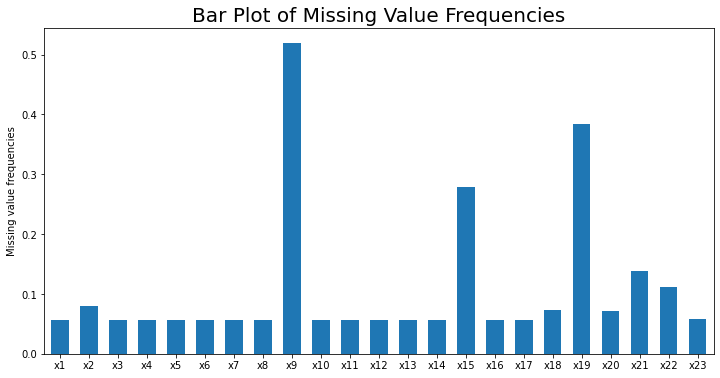

In [ ]:
#plotting the bar plot of missing value frequencies
df_missing_num = df.iloc[:, 1:].isnull().sum()
df_total_num = df.shape[0]
df_missing_freq = df_missing_num / df_total_num 
plt.figure(figsize=(12, 6))
df_missing_freq.plot.bar(width=0.60, rot=0, ax=plt.gca())
plt.ylabel('Missing value frequencies')
plt.title('Bar Plot of Missing Value Frequencies', fontsize=20)
plt.show()

As the value of missing value frequency is large enough, the representativeness of the samples may be reduced. Also, the bias would occur when estimating the parameters in the model. As shown above, X9 (Months Since Most Recent Delinquency) has high frequency of missing values, which is more than a half of samples, **X9 (Months Since Most Recent Delinquency)** is excluded in our model. Also, the values of missing value frequecy of **X15 (Months Since Most Recent Inq excl 7days)** and **x19(Net Fraction Installment Burden)** are considerable.<br>
Therefore, in our model, **X9 (Months Since Most Recent Delinquency)**,**X15 (Months Since Most Recent Inq excl 7days)** and **x19(Net Fraction Installment Burden)** are dropped.

Now, we consider the distribution of each features to impute more reasonable values for missing values in each features.

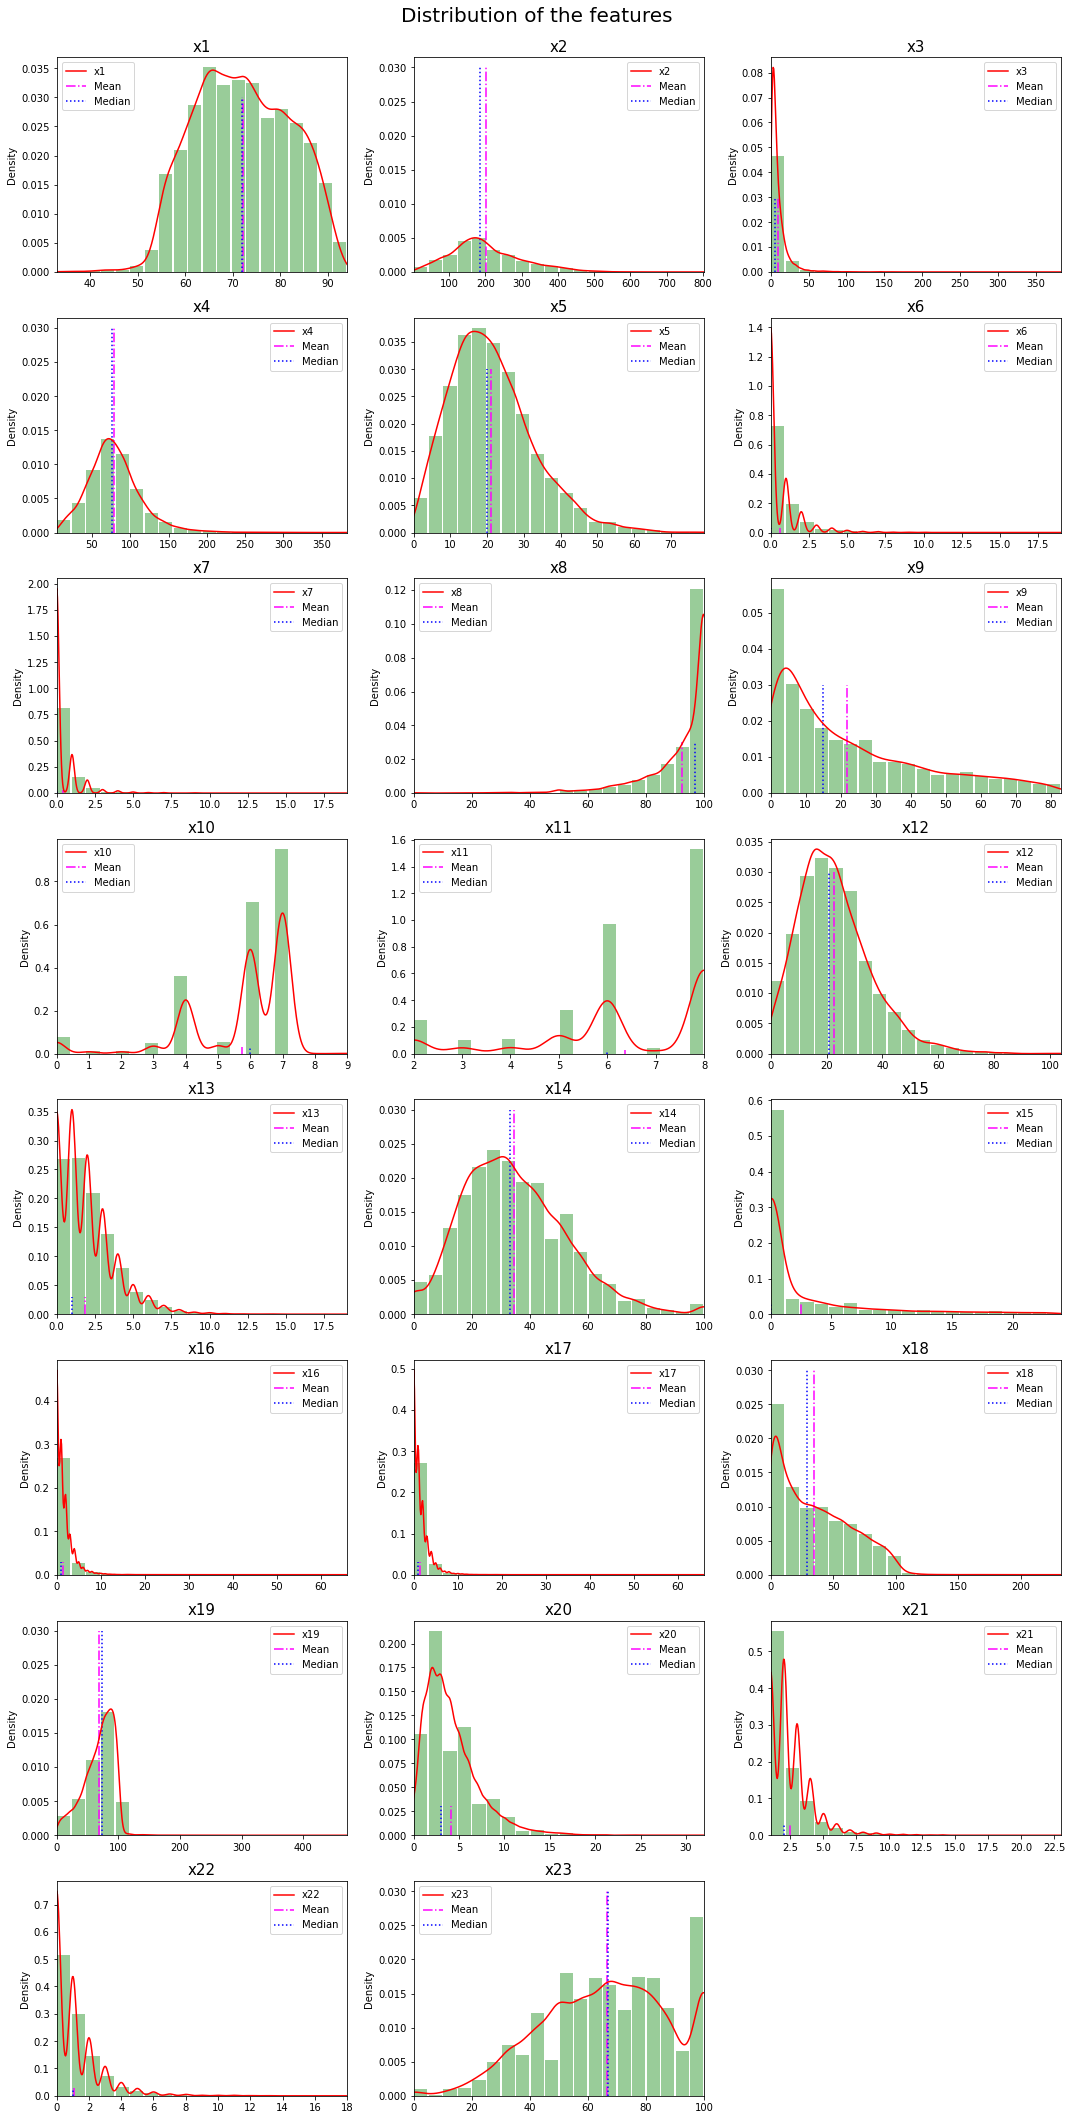

In [ ]:
# plotting histogram and the distribution of each features
cols = 3
rows = (df.shape[1]-1)//cols+1

fig = plt.figure(figsize=(30, 5*rows))
for i, var_name in enumerate(df.columns[1:]):
    ax = fig.add_subplot(rows,cols,i+1)
    #histogram
    df[var_name].hist(bins=20, rwidth=0.9, density=True,alpha=0.4,color='green', figsize=(15,30))
    #distribution
    df[var_name].plot(kind='density', color='red')

    # drawing mean and median line
    mean_line = df[var_name].mean(skipna=True)
    median_line = df[var_name].median(skipna=True)
    plt.vlines(x = mean_line,ymin=0,ymax=0.03,color='magenta',linestyles='-.',label = 'Mean')
    plt.vlines(x = median_line,ymin=0,ymax=0.03,color='blue',linestyles=':',label = 'Median')
    
    ax.set_title(var_name, fontsize = 15)
    plt.suptitle('Distribution of the features', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    plt.legend()
    # setting the domain of the plot
    plt.xlim(df.describe().T.loc[var_name]['min'],df.describe().T.loc[var_name]['max'])

plt.show()

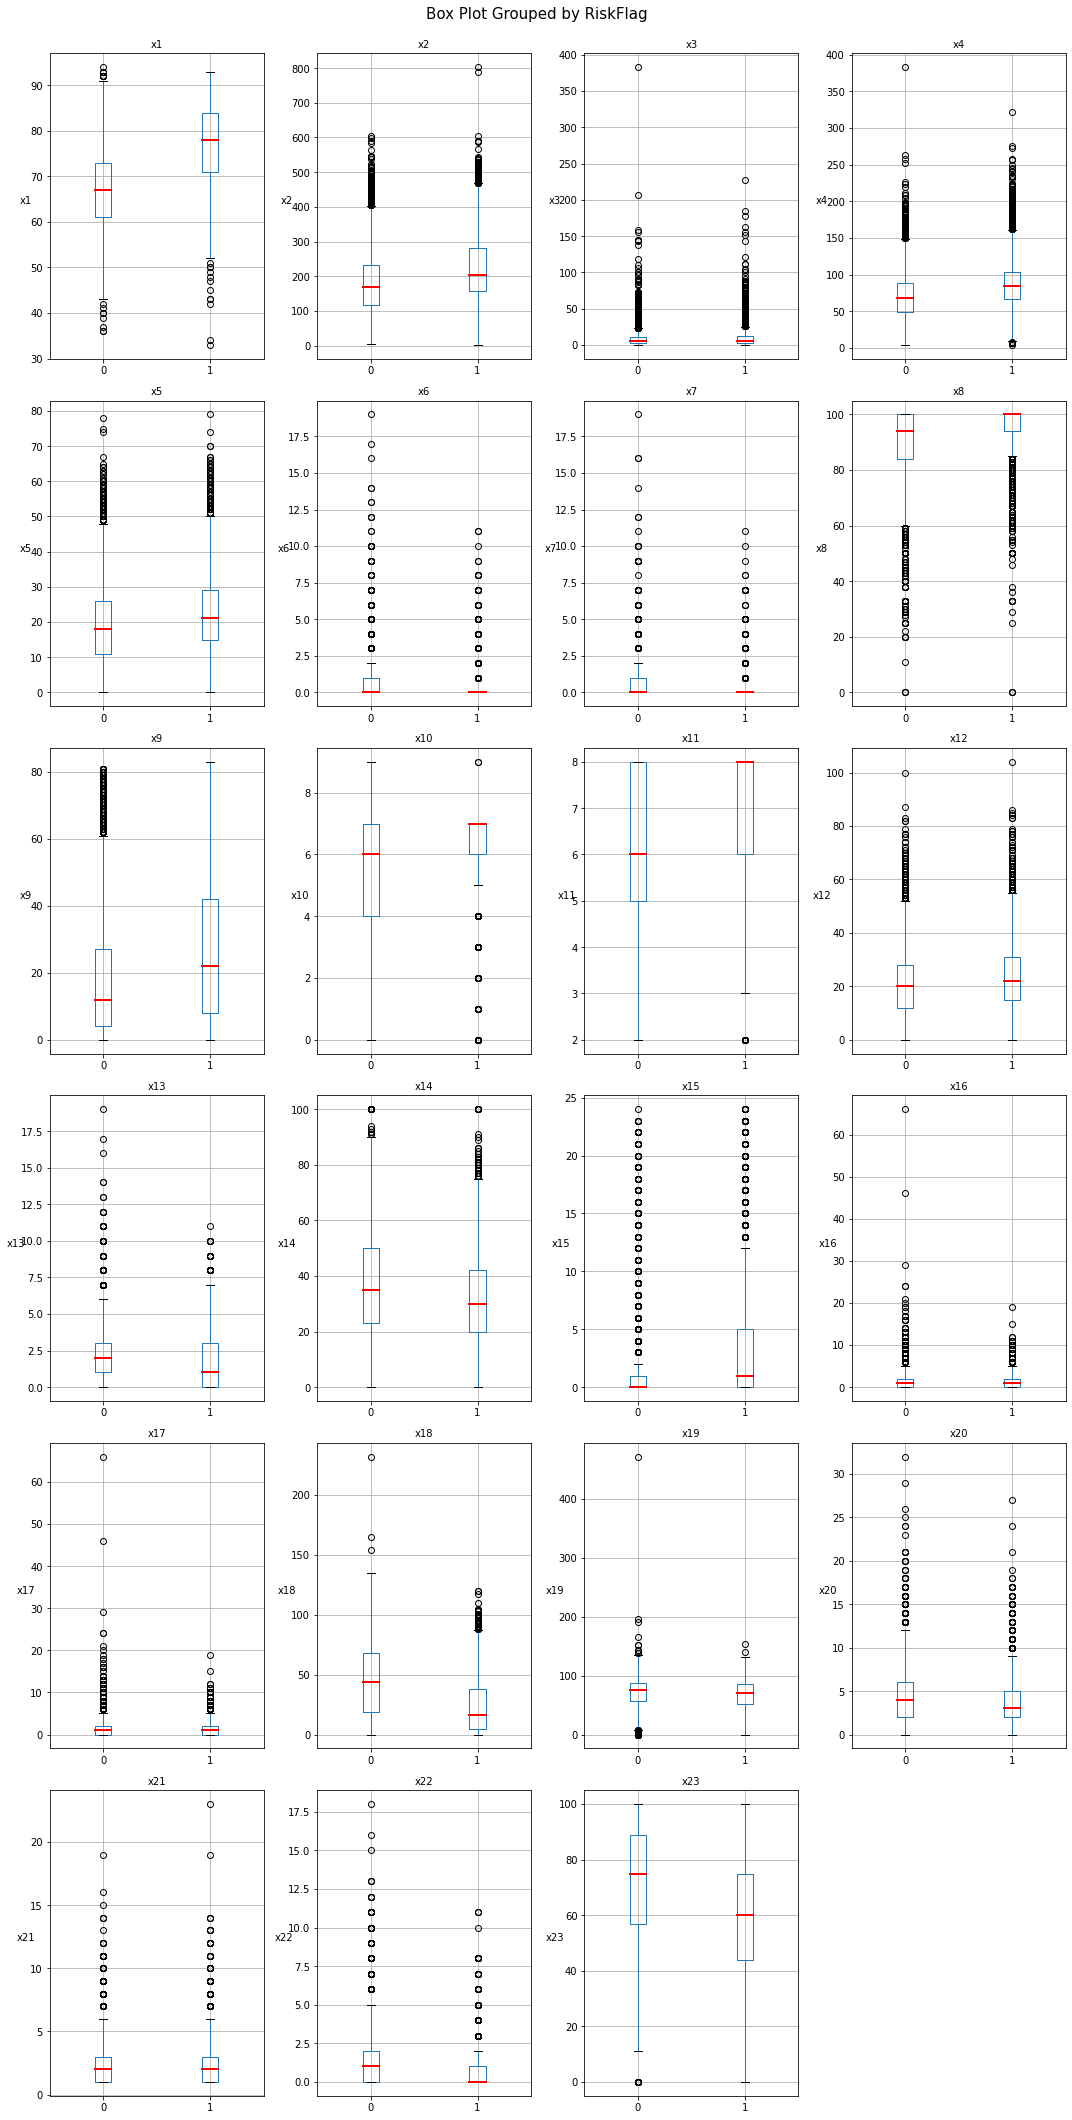

In [ ]:
#plotting box plot grouped by riskflag
cols = 4 
rows = (df.shape[1]-1)//cols + 1 

fig = plt.figure(figsize=(15, 5*rows))
for i, var_name in enumerate(df.columns[1:]):
    ax = fig.add_subplot(rows,cols,i+1)
    bp = df.boxplot(column=var_name, by='RiskFlag',
                              ax=ax, return_type='dict')
    [value.set_color('r') for value in bp[0]['medians']] 
    [value.set_linewidth(2) for value in bp[0]['medians']]

    ax.set_xlabel('')
    ax.set_ylabel(var_name, rotation=0) # annotate feature names
    ax.set_title(var_name, fontsize=10)
    
plt.suptitle('Box Plot Grouped by RiskFlag', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97]) # remove extra space
plt.show()

As shown above, some distributions are skewed than others (significant difference between the value of median and mean) and some distributions have trends based on their highest density value.

**Skewed distribution:**

x2   Months Since Oldest Trade Open<br>
x5   Number Satisfactory Trades<br>
x8   Percent Trades Never Delinquent<br>
x13  Number of Trades Open in Last 12 Months<br>
x18  Net Fraction Revolving Burden<br>
x20  Number Revolving Trades with Balance<br>

Therefore, for these 6 features, the missing values are imputed by thier median values to avoid biasedness.

**Distribution based on its mode:**

x10  Max Delq/Public Records Last 12 Months <br>
x11  Max Delinquency Ever <br>

For these 2 features, the missing values are imputed by their mode values.<br>
For rest of the features, the missing values are imputed by their mean values.

In [ ]:
# impute the missing values for both training sets and test sets
# impute skewed features with median
skewed_dist = ['x2','x5','x8','x13','x18', 'x20']
sk_imp_train = SimpleImputer(missing_values=np.nan,strategy="median")
sk_imp_test = SimpleImputer(missing_values=np.nan, strategy="median")
df_train[skewed_dist]=sk_imp_train.fit_transform(df_train[skewed_dist])
df_test[skewed_dist]=sk_imp_test.fit_transform(df_test[skewed_dist])

# impute the distribution based on its mode with mode
mode_dist = ['x10','x11']
mo_imp_train = SimpleImputer(missing_values=np.nan,strategy="most_frequent")
mo_imp_test = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df_train[mode_dist]=mo_imp_train.fit_transform(df_train[mode_dist])
df_test[mode_dist]=mo_imp_test.fit_transform(df_test[mode_dist])

# as above features are already imputed, impute the whole remainig missing values by mean
simple_imp_train = SimpleImputer(missing_values=np.nan,strategy="mean")
simple_imp_test = SimpleImputer(missing_values=np.nan, strategy="mean")
df_train.iloc[:, 1:] = simple_imp_train.fit_transform(df_train.iloc[:, 1:])
df_test.iloc[:, 1:] = simple_imp_test.fit_transform(df_test.iloc[:, 1:])

nans = df_train.iloc[:, 1:].isnull().sum().sum()
print('Number of NaNs remain:', nans)

Number of NaNs remain: 0


## c. Outlier analysis

Including the outliers into the model may reduce the predictability of
models. Hence, it is important to take few imputation methods for outliers into considerations. There are two methods suggested in convention:

1.   Using standard deviation score
2.   Using IQR Analysis

However, as shown from above in section c. Imputation, there are too many cases outside the boxes, hence this section will adopt the first method.

The first method considers the data point outside of 3 sd from the mean as outliers.

In [ ]:
def std_based_outlier(df):
    for i in range(1, len(df.iloc[1])): 
        df_outliers = df[np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) > (3*df.iloc[:,i].std())]
        return df_outliers

df_outlier = std_based_outlier(df_train)
df_outlier

RiskFlag    x1     x2    x3  ...   x20       x21     x22         x23
7708         0  43.0   71.0  11.0  ...   1.0  1.000000  1.0887  100.000000
9501         1  33.0  243.0  12.0  ...   2.0  4.000000  1.0887  100.000000
5416         0  43.0  165.0  15.0  ...  15.0  2.485933  7.0000  100.000000
2695         1  43.0  137.0   2.0  ...   2.0  2.000000  2.0000   80.000000
1436         0  36.0  110.0   6.0  ...   1.0  3.000000  1.0887  100.000000
8866         1  34.0  157.0  31.0  ...   1.0  2.485933  1.0000  100.000000
1394         1  43.0  144.0   6.0  ...   2.0  4.000000  2.0000   89.000000
6389         1  42.0  174.0   1.0  ...   2.0  5.000000  0.0000   64.000000
7985         0  43.0  255.0   3.0  ...   7.0  6.000000  5.0000   72.000000
5559         0  42.0  179.0   1.0  ...   4.0  5.000000  4.0000  100.000000
6705         0  41.0  169.0   4.0  ...  10.0  4.000000  7.0000   88.000000
6357         0  37.0  263.0   4.0  ...   7.0  2.000000  2.0000   69.000000
6459         0  36.0  377.0   1.0  ...   8.0  3.000000  2.0000   85.000000
9078         0  40.0  177.0   1.0  ...   1.0  2.000000  1.0000  100.000000
9768         0  39.0   80.0  11.0  ...   3.0  2.485933  1.0887   66.531131
4020         0  40.0  166.0   3.0  ...  11.0  1.000000  3.0000   87.000000

[16 rows x 24 columns]

Since the outliers are 16 datapoints from df_train, we may just remove those data points from the df_train.

In [ ]:
def std_based_outlier_clean(df):
    for i in range(1, len(df.iloc[1])): 
        df_outliers = df[~(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) > (3*df.iloc[:,i].std()))]
        return df_outliers

df_train = std_based_outlier_clean(df_train)
df_train

RiskFlag    x1     x2    x3     x4  ...        x19   x20  x21  x22   x23
2795          1  82.0  178.0   4.0   73.0  ...  44.000000   3.0  2.0  0.0  63.0
9142          1  87.0  133.0  11.0   88.0  ...  14.000000   1.0  1.0  0.0  67.0
808           0  77.0  229.0   3.0  109.0  ...  93.000000   4.0  3.0  1.0  58.0
10432         0  63.0  135.0   2.0   78.0  ...  68.566492   1.0  1.0  0.0  67.0
5611          1  81.0  271.0   3.0   85.0  ...  68.566492   3.0  1.0  1.0  36.0
...         ...   ...    ...   ...    ...  ...        ...   ...  ...  ...   ...
9604          1  85.0  243.0   5.0   75.0  ...  68.566492   3.0  1.0  0.0  31.0
7360          0  71.0  381.0   3.0   86.0  ...  53.000000   8.0  3.0  3.0  65.0
10322         0  84.0  158.0   6.0   83.0  ...  68.566492   1.0  1.0  0.0  67.0
1443          1  79.0  256.0  11.0   79.0  ...  54.000000   8.0  3.0  1.0  52.0
3522          0  66.0  286.0   1.0  114.0  ...  68.566492  12.0  4.0  2.0  71.0

[8351 rows x 24 columns]

## d. Correlation analysis

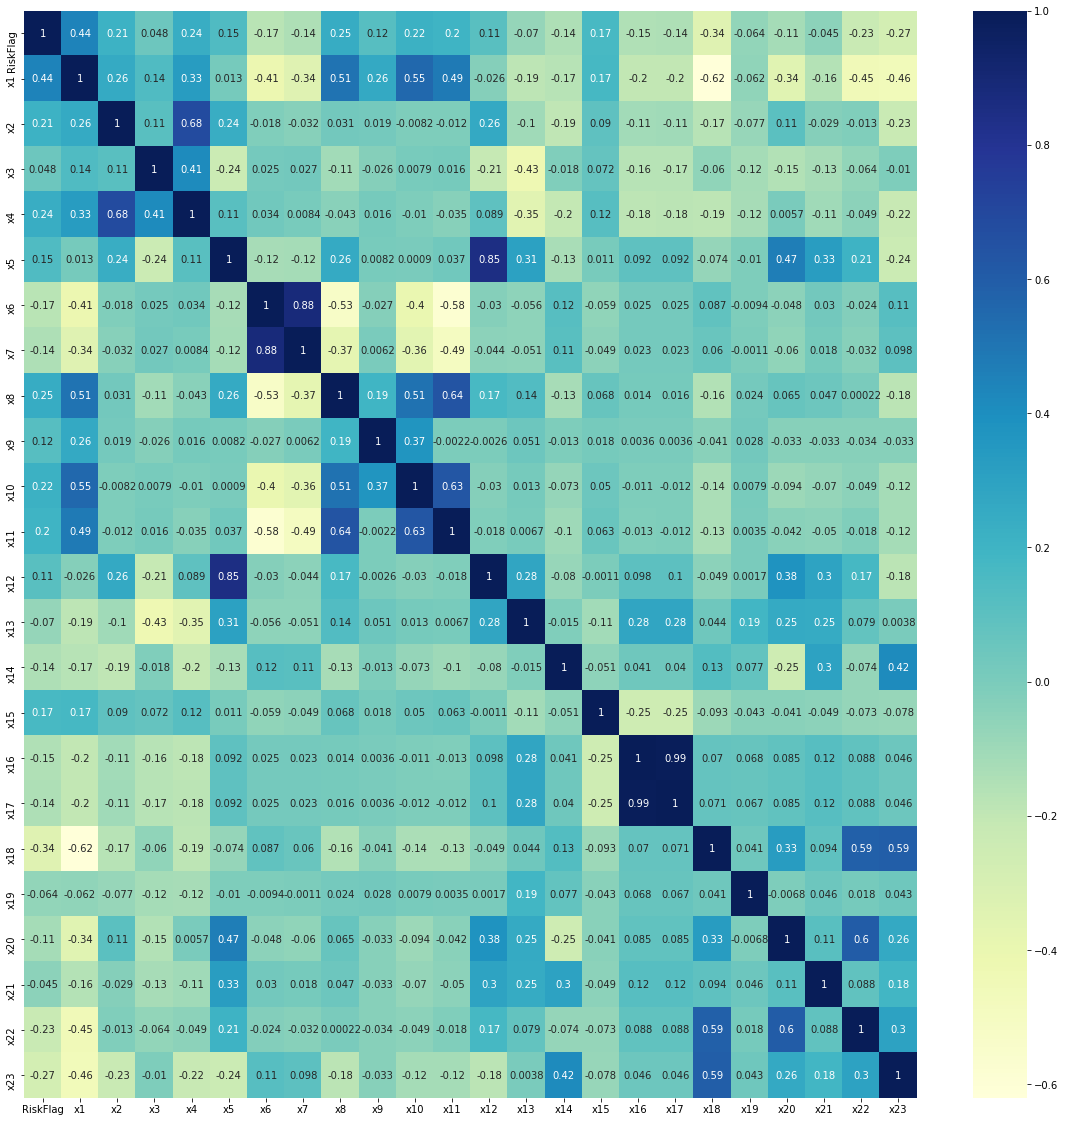

In [ ]:
# drawing a heat map
corr_mat = df_train.corr()
plt.figure(figsize=(20,20))
heat_map = sns.heatmap(df_train[corr_mat.index].corr(),annot=True,cmap="YlGnBu")

From the heat map, it is shown that

1. **'x6 Number Trades 60+ Ever'** and **'x7 Number Trades 90+ Ever'** are highly correlated
2. **'x16 Number of Inq Last 6 Months'** and **'x17 Number of Inq Last 6 Months excl 7days'** are highly correlated
3. **'x1 Consolidated version of risk markers'** is highly correlated with other features among all features while other features are not significantly correlated.
4. As **'x2 Months Since Oldest Trade Open'**,**'x4  Average Months in File'**,**'x8  Percent Trades Never Delinquent'**,**'x10  Max Delq/Public Records Last 12 Months'**,**'x11  Max Delinquency Ever'** and **'x15  Months Since Most Recent Inq excl 7days'** are relatively correlated to **'x1 Consolidated version of risk markers'**, we can say that **'x1 Consolidated version of risk markers'** can be explained in terms of these features.

## e. Analysis on individual features

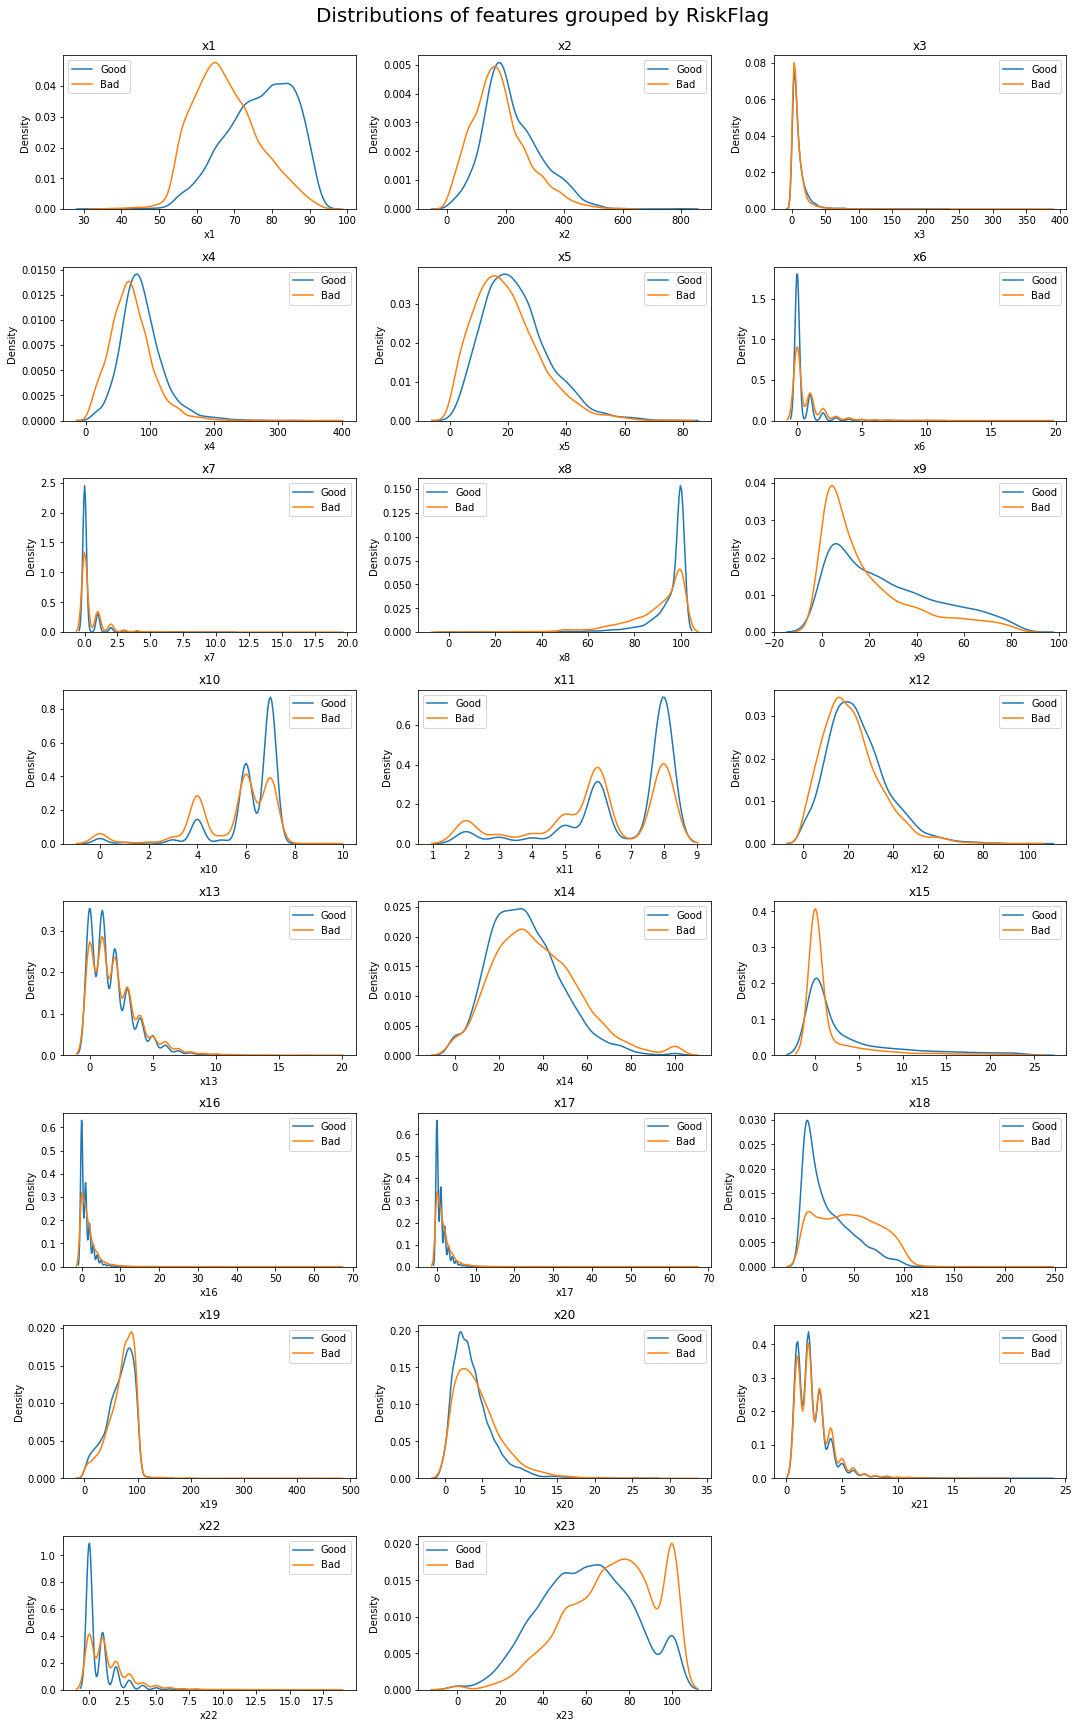

In [ ]:
plt.figure(figsize=(15,30))
for i, var_name in enumerate(df.columns[1:]):
    plt.subplot(10, 3, i + 1)
    sns.kdeplot(df.loc[df['RiskFlag'] == 1, var_name], label = 'Good')
    sns.kdeplot(df.loc[df['RiskFlag'] == 0, var_name], label = 'Bad')
    
    plt.legend()
    plt.ylabel('Density')
    plt.title(var_name)
    
plt.suptitle('Distributions of features grouped by RiskFlag', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97]) 

Now, we can intuitively explain each features grouped by RiskFlag from above distribution table.
1. For **'x6 Number Trades 60+ Ever'** and **'x7 Number Trades 90+ Ever'**, people with bad risk had lower number of trades than people with good risk.
2. For **'x8 Percent Trades Never Delinquent'**, people with good risk have significantly higher percent of trades that is never delinquent while for **'x9 Months Since Most Recent Delinquency'**, the people with bad risk were dominant.
4. For **'x10 Max Delq/Public Records Last 12 Months'** and **'x11 Max Delinquency Ever'**, people with good risk had less delinquent trades, which were mostly 'unknown','current and never delinqeunt', etc.
5. For **'x15 Months Since Most Recent Inq excl 7days'**,**'x16	Number of Inq Last 6 Months'** and **'x17	Number of Inq Last 6 Months excl 7days'** , the people with good risk had significantly lower number of Inq.
6. For **'x18	Net Fraction Revolving Burden'**, **'x22 Number Bank/Natl Trades w high utilization ratio'** and **'x23	Percent Trades with Balance'**, the people with good risk had lower fraction of revolving burden, lower number of trades with high utilization ratio and lower percent trades with balace.

# 4. Feature Engineering

a. Feature Selection<br>
b. One-hot Encoding for x10 and x11<br>
c. Feature Scaling<br>


## a. Feature Selection

Through feature selection process, we can reduce the running time and reduce the varaiances of models in order to robustly learn data. Plus, better interpretability of the models.<br>

**The feature selection metrics are followings:**

1. *Missing Values*<br>

    -> Based on the result from section 3b, **X9 (Months Since Most Recent Delinquency)**, **X15 (Months Since Most Recent Inq excl 7days)**, and **x19(Net Fraction Installment Burden)** are excluded in our model.<br>
2. *Multicolinearity*<br>

    -> Since **x6 (Number Trades 60+ Ever)** and **x7 (Number Trades 90+ Ever)** are highly correlated (0.89), and **x16 (Number of Inq Last 6 Months)** and **x17 (Number of Inq Last 6 Months excl 7days)** are extremely highly correlated (0.99), we can drop one feature from each pair. <br>


In [ ]:
#x_train,x_test,y_train and y_test before the feature selection
X_train=df_train.iloc[:,1:]
X_test=df_test.iloc[:,1:]
y_train=df_train.iloc[:,0]
y_test=df_test.iloc[:,0]
X_train

x1     x2    x3     x4    x5  ...        x19   x20  x21  x22   x23
2795   82.0  178.0   4.0   73.0  18.0  ...  44.000000   3.0  2.0  0.0  63.0
9142   87.0  133.0  11.0   88.0  14.0  ...  14.000000   1.0  1.0  0.0  67.0
808    77.0  229.0   3.0  109.0  23.0  ...  93.000000   4.0  3.0  1.0  58.0
10432  63.0  135.0   2.0   78.0   6.0  ...  68.566492   1.0  1.0  0.0  67.0
5611   81.0  271.0   3.0   85.0  19.0  ...  68.566492   3.0  1.0  1.0  36.0
...     ...    ...   ...    ...   ...  ...        ...   ...  ...  ...   ...
9604   85.0  243.0   5.0   75.0  22.0  ...  68.566492   3.0  1.0  0.0  31.0
7360   71.0  381.0   3.0   86.0  38.0  ...  53.000000   8.0  3.0  3.0  65.0
10322  84.0  158.0   6.0   83.0   5.0  ...  68.566492   1.0  1.0  0.0  67.0
1443   79.0  256.0  11.0   79.0  42.0  ...  54.000000   8.0  3.0  1.0  52.0
3522   66.0  286.0   1.0  114.0  45.0  ...  68.566492  12.0  4.0  2.0  71.0

[8351 rows x 23 columns]

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
best = 10
X_norm = preprocessing.MinMaxScaler().fit_transform(X_train)
chi_selector = SelectKBest(chi2, k=best)
chi_selector.fit(X_norm, y_train)
chi_support = chi_selector.get_support()
chi_feature = X_train.loc[:,chi_support].columns.tolist()
chi_feature

['x1', 'x2', 'x6', 'x7', 'x10', 'x11', 'x15', 'x18', 'x22', 'x23']

The ranking of features under chi2 test are: <br>
'x1', 'x18', '15', 'x22', 'x23', 'x11', 'x6', 'x4', 'x2', 'x10', 'x7', 'x9', 'x14' ... <br>

In [ ]:
#X_train and X_test with selected features
selected_features=['x1','x2','x3','x4','x5','x6','x8','x10','x11','x12','x13','x14','x16','x18','x20','x21','x22','x23']
X_train_final=X_train[selected_features]
X_test_final=X_test[selected_features]

X_train_final

x1     x2    x3     x4    x5   x6  ...  x16   x18   x20  x21  x22   x23
2795   82.0  178.0   4.0   73.0  18.0  0.0  ...  4.0   4.0   3.0  2.0  0.0  63.0
9142   87.0  133.0  11.0   88.0  14.0  0.0  ...  0.0   3.0   1.0  1.0  0.0  67.0
808    77.0  229.0   3.0  109.0  23.0  0.0  ...  0.0  38.0   4.0  3.0  1.0  58.0
10432  63.0  135.0   2.0   78.0   6.0  4.0  ...  2.0  31.0   1.0  1.0  0.0  67.0
5611   81.0  271.0   3.0   85.0  19.0  0.0  ...  1.0   6.0   3.0  1.0  1.0  36.0
...     ...    ...   ...    ...   ...  ...  ...  ...   ...   ...  ...  ...   ...
9604   85.0  243.0   5.0   75.0  22.0  0.0  ...  4.0   4.0   3.0  1.0  0.0  31.0
7360   71.0  381.0   3.0   86.0  38.0  0.0  ...  3.0  35.0   8.0  3.0  3.0  65.0
10322  84.0  158.0   6.0   83.0   5.0  0.0  ...  0.0  41.0   1.0  1.0  0.0  67.0
1443   79.0  256.0  11.0   79.0  42.0  0.0  ...  0.0  17.0   8.0  3.0  1.0  52.0
3522   66.0  286.0   1.0  114.0  45.0  0.0  ...  0.0  67.0  12.0  4.0  2.0  71.0

[8351 rows x 18 columns]

## b. One hot encoding for x10 and x11

In [ ]:
X_train = pd.get_dummies(X_train_final, columns=['x10','x11'], drop_first=True)
X_test = pd.get_dummies(X_test_final, columns=['x10','x11'], drop_first=True)

X_train

x1     x2    x3     x4  ...  x11_5.0  x11_6.0  x11_7.0  x11_8.0
2795   82.0  178.0   4.0   73.0  ...        0        1        0        0
9142   87.0  133.0  11.0   88.0  ...        0        0        0        1
808    77.0  229.0   3.0  109.0  ...        0        0        0        1
10432  63.0  135.0   2.0   78.0  ...        0        0        0        0
5611   81.0  271.0   3.0   85.0  ...        0        1        0        0
...     ...    ...   ...    ...  ...      ...      ...      ...      ...
9604   85.0  243.0   5.0   75.0  ...        0        0        0        1
7360   71.0  381.0   3.0   86.0  ...        0        0        0        1
10322  84.0  158.0   6.0   83.0  ...        0        0        0        1
1443   79.0  256.0  11.0   79.0  ...        0        0        0        1
3522   66.0  286.0   1.0  114.0  ...        0        1        0        0

[8351 rows x 30 columns]

## c. Feature Scaling

In [ ]:
std_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scd = std_scaler.transform(X_train)
X_train_scd     # X_train with standardly scaled
X_test_scd = std_scaler.transform(X_test)
X_test_scd     # X_test with standardly scaled

array([[-0.54236964, -1.52568484, -0.66585104, ...,  1.6254088 ,
        -0.11338552, -0.98160844],
       [ 0.93416322,  0.75975273,  0.03156782, ..., -0.61522984,
        -0.11338552,  1.01873614],
       [ 0.40683005,  0.11897585, -0.66585104, ..., -0.61522984,
        -0.11338552,  1.01873614],
       ...,
       [ 0.30136342, -0.61791758, -0.27839612, ..., -0.61522984,
        -0.11338552,  1.01873614],
       [-0.96423617, -0.54316027, -0.20090513, ..., -0.61522984,
        -0.11338552, -0.98160844],
       [-1.0697028 ,  1.14421887,  0.72898667, ...,  1.6254088 ,
        -0.11338552, -0.98160844]])

# 5. Set 1: Without Monotonicity Constraints

a. Logistic Regression<br>
b. General Additive Model<br>
c. Decision Tree<br>
d. Support Vector Machine<br>
e. Gradient Boosting: XGBoost<br>
f. Artificial Neural Network



**From regression model:** We have chosen logistic regression (assumed high interpretability) and GAM (assumed high performance).<br>
IV binning has been used for logistic regression model, and b-spline and piecewise linear basis function are adopted for GAM.

**From support vector classifer:** We have adopted two different types of kernels: linear and rbf.

**From tree-based methods:** We have chosen decision tree (assumed high interpretability) and XGBoost (assumed high performance).

**From network model:** We have adopted feed forward neural network: ReLU Multilyer Perceptron

Hyperparameter tuning using gridsearchCV has been adopted for models which are necessary.

## a. Logistic Regression

We first check the fit to the 10 features

In [ ]:
#Fitting the logistic model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e8, solver='newton-cg')
logreg.fit(X_train, y_train)

#Coefficients of the model
print("Coefficients :", np.round(logreg.intercept_,4), np.round(logreg.coef_,4))

Coefficients : [-5.6531] [[ 5.3900e-02  9.0000e-04 -4.9000e-03  7.4000e-03  3.4400e-02 -6.8200e-02
   1.0600e-02  7.0000e-04 -1.1800e-02 -8.8000e-03 -1.2930e-01 -8.8000e-03
  -4.4700e-02  4.0000e-03 -1.2400e-01  3.3000e-03  4.0620e-01 -1.1070e-01
   2.3170e-01 -1.1700e-01 -4.7280e-01  2.2740e-01  2.4260e-01 -1.1971e+00
   1.6910e-01  6.6200e-02 -5.2100e-02 -1.2040e-01  9.2800e-02  2.2100e-02]]


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# accuracy score 
performance={}

y_pred_train = logreg.predict(X_train)
y_pred_test = logreg.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print('Accuracy on the training set =', np.round(accuracy_train,4))
print('Accuracy on the test set =', np.round(accuracy_test,4))

Accuracy on the training set = 0.717
Accuracy on the test set = 0.7051


In [ ]:
#Summary of the statistic
X1 = sm.add_constant(X_train)
logreg = sm.Logit(y_train,X1).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.555938
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RiskFlag   No. Observations:                 8351
Model:                          Logit   Df Residuals:                     8320
Method:                           MLE   Df Model:                           30
Date:                Mon, 30 Nov 2020   Pseudo R-squ.:                  0.1969
Time:                        22:03:36   Log-Likelihood:                -4642.6
converged:                       True   LL-Null:                       -5780.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6531      0.532    -10.629      0.000      -6.696      -4.611
x1             0.0539      0.

P|z| of x11_4.0 is very large, which indicates high probability of not being statistically relevant, we can therefore drop it.

In [ ]:
#Refining the model
def df_preprocesser2(df, x18_breaks=None, x22_breaks=None, set='train'):
    df_tmp = df.copy()
    df_tmp.drop(df_tmp.columns.difference(['RiskFlag','x1','x2','x3','x4','x5','x6','x8','x10','x11','x12','x13','x14','x16','x18','x20','x21','x22','x23']), 1, inplace=True)
    
    # use IV binning
    if set=='train':
      x22_bins = sc.woebin(df_tmp, y='RiskFlag',x='x22', method='tree')
      x22_breaks = np.insert(x22_bins['x22']['breaks'].values.astype(np.float), 0, -np.inf)
    df_tmp['x22'] = pd.cut(df_tmp['x22'], bins=x22_breaks, right=True)
    df_tmp

    if set=='train':
      x18_bins = sc.woebin(df_tmp, y='RiskFlag',x='x18', method='tree')
      x18_breaks = np.insert(x18_bins['x18']['breaks'].values.astype(np.float), 0, -np.inf)
    df_tmp['x18'] = pd.cut(df_tmp['x18'], bins=x18_breaks, right=True)
    df_tmp

   # one-hot encoding
    df_tmp = pd.get_dummies(df_tmp, columns=['x10','x11','x22','x18'], drop_first=True)

    return df_tmp, x18_breaks, x22_breaks

In [ ]:
df_train_log = df_train.copy()
df_test_log = df_test.copy()

df_train_log, x18_breaks, x22_breaks = df_preprocesser2(df_train, set='train')
df_test_log= df_preprocesser2(df_test_log, x18_breaks, x22_breaks, set='test')[0]

#This bin is dropped due to high chance of not being 
df_train_log = df_train_log.drop(columns=['x11_4.0','x11_6.0'])
df_test_log = df_test_log.drop(columns=['x11_4.0','x11_6.0'])


#x_train,x_test,y_train and y_test before the feature selection
X_train_log=df_train_log.iloc[:,1:]
X_test_log=df_test_log.iloc[:,1:]
y_train_log=df_train_log.iloc[:,0]
y_test_log=df_test_log.iloc[:,0]

X_train_log.head()

[INFO] creating woe binning ...
[INFO] creating woe binning ...


x1     x2    x3  ...  x18_(15.0, 25.0]  x18_(25.0, 60.0]  x18_(60.0, inf]
2795   82.0  178.0   4.0  ...                 0                 0                0
9142   87.0  133.0  11.0  ...                 0                 0                0
808    77.0  229.0   3.0  ...                 0                 1                0
10432  63.0  135.0   2.0  ...                 0                 1                0
5611   81.0  271.0   3.0  ...                 0                 0                0

[5 rows x 31 columns]

In [ ]:
logreg = LogisticRegression(C=1e8, solver='newton-cg')
logreg.fit(X_train_log, y_train_log)

print("Coefficients :", np.round(logreg.intercept_,4), np.round(logreg.coef_,4))

Coefficients : [-5.6049] [[ 5.2900e-02  9.0000e-04 -5.0000e-03  7.6000e-03  3.3600e-02 -4.3700e-02
   9.7000e-03  1.4000e-03 -1.4400e-02 -8.4000e-03 -1.2920e-01 -5.7700e-02
   5.0000e-03  3.3000e-03  3.4970e-01  3.9000e-03  2.1650e-01 -1.3650e-01
  -4.6570e-01  2.2420e-01  3.0510e-01 -1.0237e+00  1.9510e-01  1.1500e-02
   1.9530e-01  1.0670e-01 -2.3890e-01 -4.6490e-01 -2.4760e-01 -3.5950e-01
  -7.4680e-01]]


In [ ]:
# accuracy score 
y_pred_train_log = logreg.predict(X_train_log)
y_pred_test_log = logreg.predict(X_test_log)

accuracy_train = accuracy_score(y_train_log, y_pred_train_log)
accuracy_test = accuracy_score(y_test_log, y_pred_test_log)

performance['Logistic Regression with IV binning : ']=np.round(accuracy_test,4)
print('Accuracy on the training set =', np.round(accuracy_train,4))
print('Accuracy on the test set =', np.round(accuracy_test,4))

Accuracy on the training set = 0.7224
Accuracy on the test set = 0.7089


We see that the accuracy for the test data is slightly higher than the accuracy for the training data, which shows that no regularisation is needed due to low chance of overfitting.

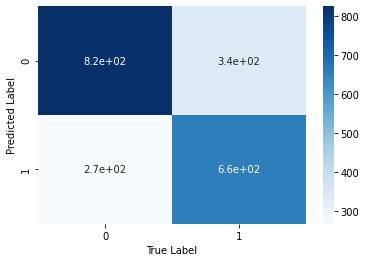

In [ ]:
#Confusion matrix
import seaborn as sn
cf_mat = confusion_matrix(y_test_log, y_pred_test_log).T
sn.heatmap(cf_mat,annot=True,cmap='Blues')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

In [ ]:
X1 = sm.add_constant(X_train_log)
logreg = sm.Logit(y_train,X1).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.556266
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RiskFlag   No. Observations:                 8351
Model:                          Logit   Df Residuals:                     8319
Method:                           MLE   Df Model:                           31
Date:                Mon, 30 Nov 2020   Pseudo R-squ.:                  0.1964
Time:                        15:36:31   Log-Likelihood:                -4645.4
converged:                       True   LL-Null:                       -5780.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.6049      0.540    -10.382      0.000      -6.663      -4.547
x1         

x1, x18, x4, x2, x22_(1.0, 3.0] are the most important features, in order for the logistic model


In [ ]:
data_dict.loc[[1,18,4,2,22]]

Variable Names  ... Monotonicity Constraint w.r.t. Prob(Bad = 1)
1              x1  ...                     Monotonically Decreasing
18            x18  ...                     Monotonically Increasing
4              x4  ...                     Monotonically Decreasing
2              x2  ...                     Monotonically Decreasing
22            x22  ...                     Monotonically Increasing

[5 rows x 3 columns]

We see that the last bin of x18 has a much higher importance compared to the first two, we can infer that a greater balance to credit limit ratio has more importance to the model. Intuitively this means that the more outstanding balance has compared credit an applicant has, the applicant becomes less risky only when the balance is overwhelmingly high

##b. General Additive Model


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29)


  9% (1 of 11) |##                       | Elapsed Time: 0:00:22 ETA:   0:03:49

did not converge


 18% (2 of 11) |####                     | Elapsed Time: 0:00:37 ETA:   0:02:07

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:01:00 Time:  0:01:00


The Accuracy on training set: 0.7178780984313256
The Accuracy on testing set: 0.7093690248565966


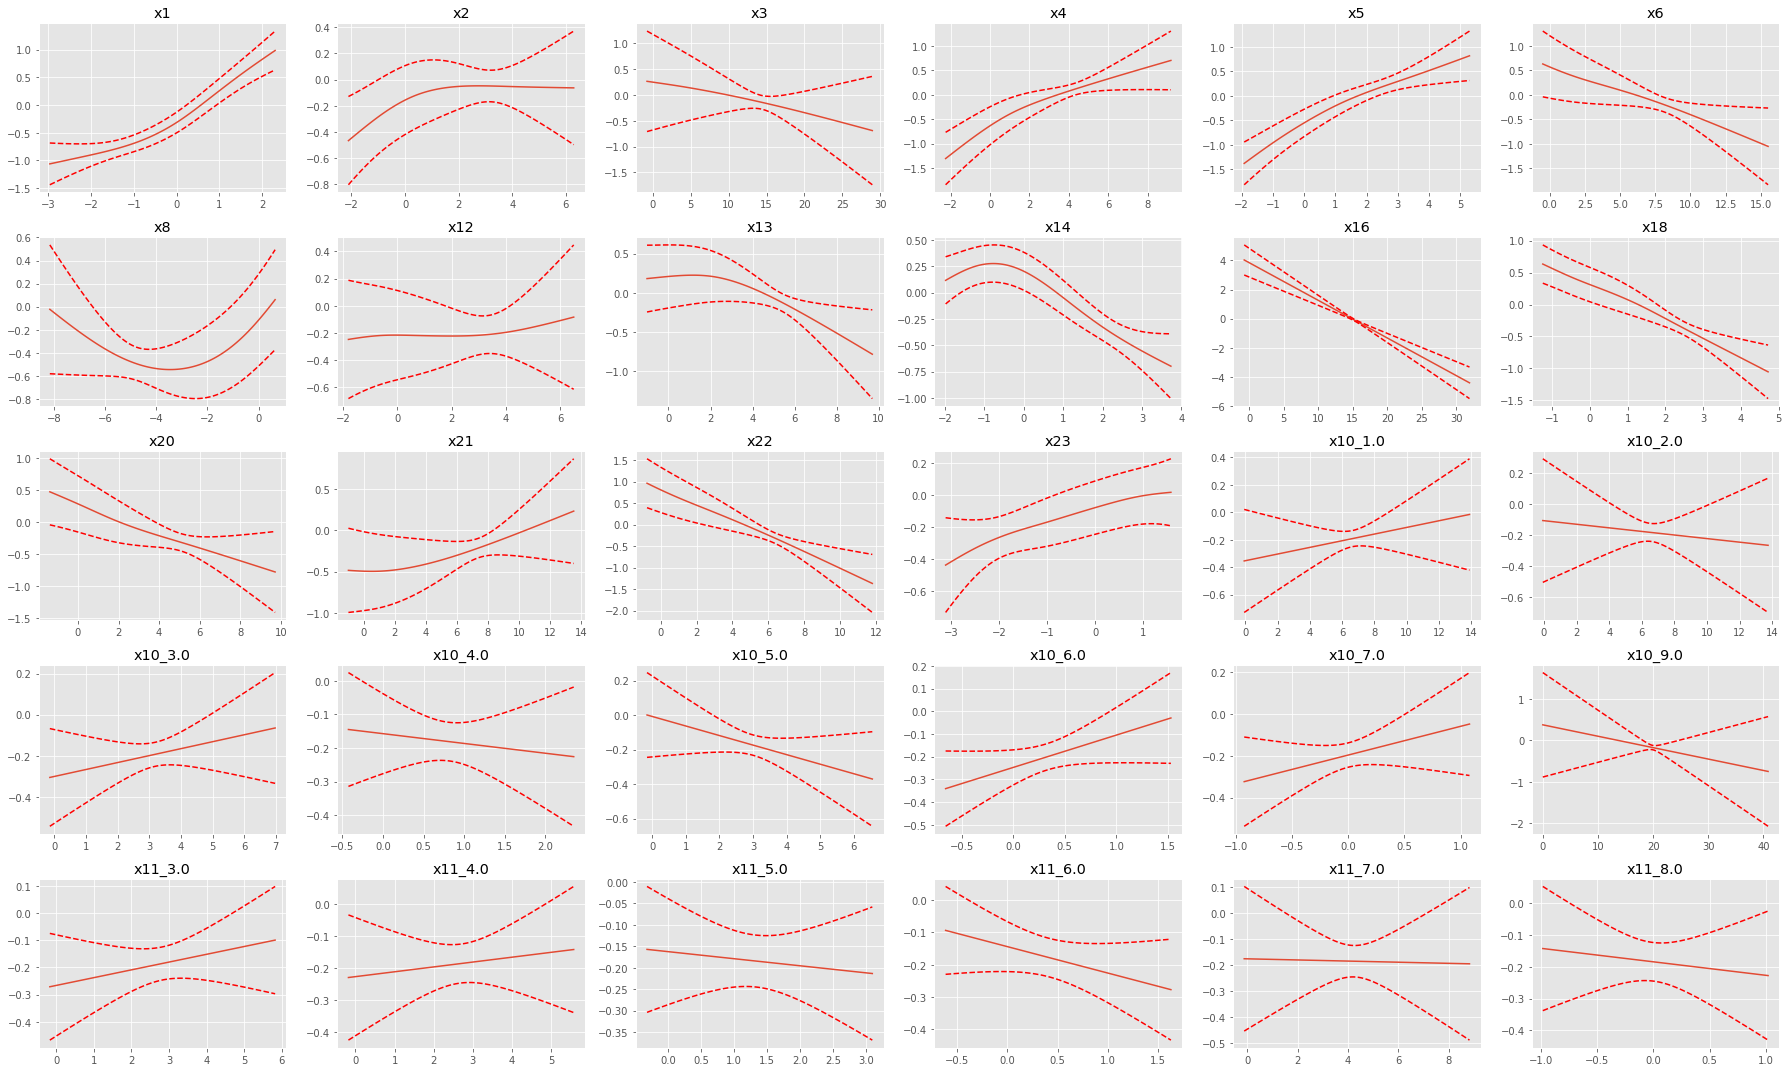

In [ ]:
#B Spline
import warnings
warnings.filterwarnings("ignore")

from pygam import LogisticGAM, s

X_train_GAM_bspline = X_train_scd
n_splines = 10

k=s(0,n_splines=n_splines)
for i in range(1,30):
  k += s(i,n_splines=n_splines)
print(k)

p_spl = LogisticGAM(k)
p_spl.gridsearch(X_train_GAM_bspline,y_train)

y_pred_train = p_spl.predict(X_train_GAM_bspline)
y_pred_test = p_spl.predict(X_test_scd)

print('The Accuracy on training set:',accuracy_score(y_train,y_pred_train))
print('The Accuracy on testing set:',accuracy_score(y_test,y_pred_test))

# partial dependence plot
fig, axs = plt.subplots(5,6,figsize=(25,15))
for i, ax in enumerate(axs.flatten()):
    XX = p_spl.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:,i], p_spl.partial_dependence(term=i, X=XX))
    plt.plot(XX[:,i], p_spl.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(X_train.columns[i])
plt.tight_layout()

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29)


100% (11 of 11) |########################| Elapsed Time: 0:00:21 Time:  0:00:21


The Accuracy on training set: 0.7183570829840737
The Accuracy on testing set: 0.7074569789674953


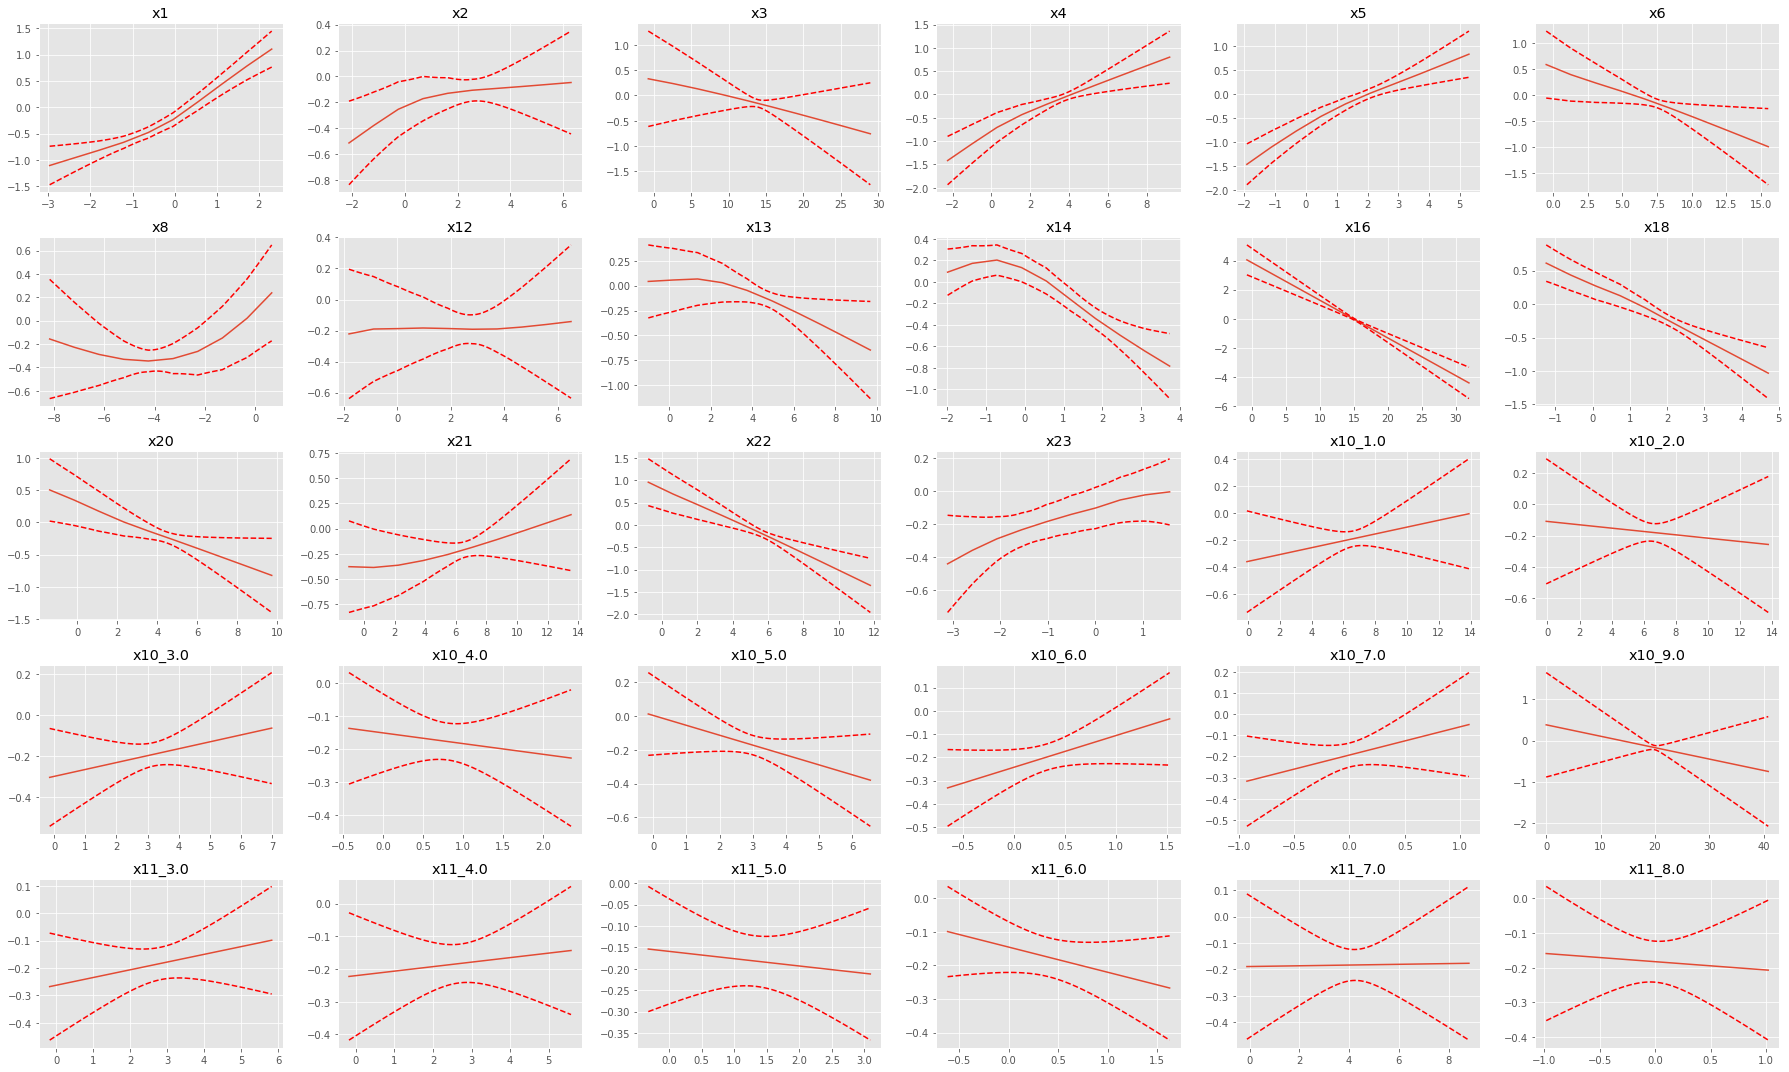

In [ ]:
#Piecewise ReLu
from pygam import LogisticGAM, s

X_train_GAM_ReLu = X_train_scd
n_splines = 10

k=s(0,n_splines=n_splines, spline_order=1)
for i in range(1,30):
  k += s(i,n_splines=n_splines, spline_order=1)
print(k)

p_spl = LogisticGAM(k)
p_spl.gridsearch(X_train_GAM_ReLu,y_train)

y_pred_train = p_spl.predict(X_train_GAM_ReLu)
y_pred_test = p_spl.predict(X_test_scd)

performance['General Additive Model with Piecewise ReLU : ']=np.round(accuracy_score(y_test,y_pred_test),4)

print('The Accuracy on training set:',accuracy_score(y_train,y_pred_train))
print('The Accuracy on testing set:',accuracy_score(y_test,y_pred_test))

# partial dependence plot
fig, axs = plt.subplots(5,6,figsize=(25,15))
for i, ax in enumerate(axs.flatten()):
    XX = p_spl.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:,i], p_spl.partial_dependence(term=i, X=XX))
    plt.plot(XX[:,i], p_spl.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(X_train.columns[i])
plt.tight_layout()

##c. Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

Linear SVC

In [ ]:
#Standardizing testing data
X_test_scd = std_scaler.transform(X_test)

linSVC = SVC(kernel='linear', C=1, random_state=1)
linSVC.fit(X_train_scd, y_train)
y_train_pred_linSVC = linSVC.predict(X_train_scd)
y_test_pred_linSVC = linSVC.predict(X_test_scd)

print('The accuracy on the train set is: {}'.format(accuracy_score(y_train, y_train_pred_linSVC).round(5)))
print('The accuracy on the test set is: {}'.format(accuracy_score(y_test, y_test_pred_linSVC).round(5)))

The accuracy on the train set is: 0.71608
The accuracy on the test set is: 0.71033


In [ ]:
#Stochastic gradient descent version of svm
sgd = SGDClassifier(loss='hinge')

sgd.fit(X_train_scd, y_train)
y_train_pred_sgd = sgd.predict(X_train_scd)
y_test_pred_sgd = sgd.predict(X_test_scd)

print('The accuracy on the train set is: {}'.format(accuracy_score(y_train, y_train_pred_sgd).round(5)))
print('The accuracy on the test set is: {}'.format(accuracy_score(y_test, y_test_pred_sgd).round(5)))

The accuracy on the train set is: 0.70926
The accuracy on the test set is: 0.7108


RBF SVC

In [ ]:
#DEFAULT: Gamma = 'scale' , C = 1.0
rbfSVC = SVC(kernel='rbf')
rbfSVC.fit(X_train_scd, y_train)
y_train_pred_rbfSVC = rbfSVC.predict(X_train_scd)
y_test_pred_rbfSVC = rbfSVC.predict(X_test_scd)

performance['RBF SVC : ']=accuracy_score(y_test, y_test_pred_rbfSVC).round(4)

print('The accuracy on the train set is: {}'.format(accuracy_score(y_train, y_train_pred_rbfSVC).round(5)))
print('The accuracy on the test set is: {}'.format(accuracy_score(y_test, y_test_pred_rbfSVC).round(5)))

The accuracy on the train set is: 0.74638
The accuracy on the test set is: 0.71367


RBF SVC with hyperparameter tuning

In [ ]:
tuned_parameters = {'kernel': ['rbf'], 'gamma':[0.0001, 0.001, 0.01, 0.1, 1.0],
                     'C': [0.01,0.1,1.0]}
svc_gs = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='accuracy')
svc_gs.fit(X_train_scd, y_train)
print('Best Parameters:',svc_gs.best_params_)

Best Parameters: {'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
y_train_pred_gs= svc_gs.predict(X_train_scd)
y_test_pred_gs= svc_gs.predict(X_test_scd)

print('The accuracy on the train set is: {}'.format(accuracy_score(y_train, y_train_pred_gs).round(5)))
print('The accuracy on the test set is: {}'.format(accuracy_score(y_test, y_test_pred_gs).round(5)))

The accuracy on the train set is: 0.715
The accuracy on the test set is: 0.7108


Interpretation

In [ ]:
!pip install interpret

     |████████████████████████████████| 5.2MB 5.1MB/s 
     |████████████████████████████████| 1.8MB 40.7MB/s 
     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 5.3MB 34.7MB/s 
     |████████████████████████████████| 3.6MB 38.3MB/s 
     |████████████████████████████████| 471kB 31.0MB/s 
     |████████████████████████████████| 276kB 31.9MB/s 
     |████████████████████████████████| 122kB 41.2MB/s 
     |████████████████████████████████| 788kB 45.8MB/s 
     |████████████████████████████████| 860kB 40.7MB/s 
     |████████████████████████████████| 327kB 28.7MB/s 
     |████████████████████████████████| 1.0MB 41.4MB/s 
     |████████████████████████████████| 3.5MB 37.5MB/s 
     |████████████████████████████████| 194kB 40.8MB/s 
     |████████████████████████████████| 245kB 40.0MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 358kB 40.2MB/s 
     |████████████████████████████████| 358kB 44.7MB/

In [ ]:
!pip install azureml-interpret

  Using cached https://files.pythonhosted.org/packages/49/be/a678bac6f4e65b1440c4922837d526bf903a1a16616edcd690caa45f9935/interpret_core-0.2.1-py3-none-any.whl
ERROR: interpret 0.2.2 has requirement interpret-core[dash,debug,decisiontree,ebm,lime,linear,notebook,plotly,required,sensitivity,shap,treeinterpreter]>=0.2.2, but you'll have interpret-core 0.2.1 which is incompatible.
  Found existing installation: interpret-core 0.2.2
    Uninstalling interpret-core-0.2.2:
      Successfully uninstalled interpret-core-0.2.2


Features: 'x1', 'x2', 'x4', 'x6', 'x14', 'x18', 'x22', 'x23', 'x10'encoded,  'x11'encoded

In [ ]:
from interpret.blackbox import PartialDependence

pdp = PartialDependence(predict_fn=svc_gs.predict, data=X_train_scd)
pdp_global = pdp.explain_global(name='Partial Dependence Plot')

show(pdp_global)

## d. Decision Tree

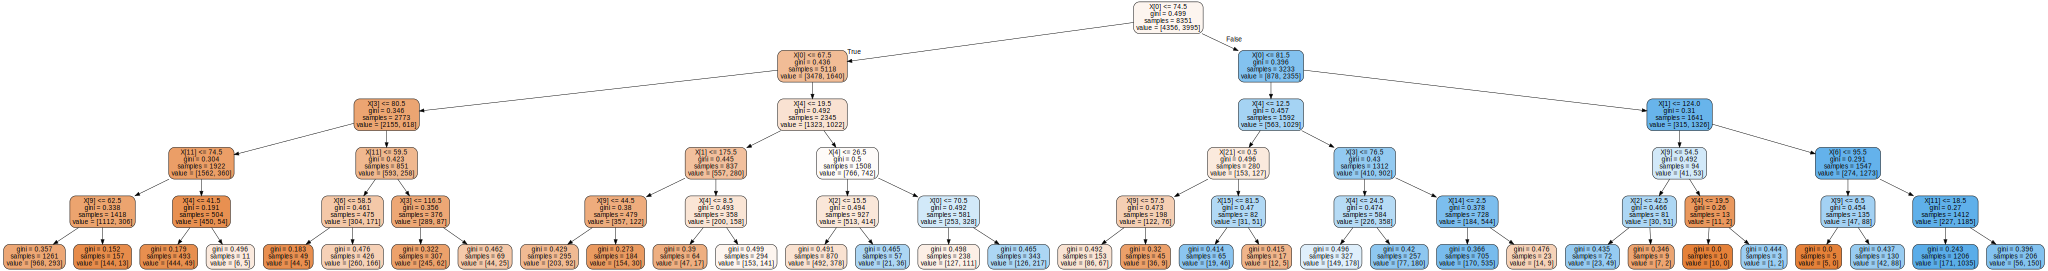

In [ ]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score
import graphviz
from sklearn.tree import export_graphviz

#Fitting Decision Tree Classifier
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)

#Visualizing the tree
dot_graph = export_graphviz(
        dt,
        out_file=None,
        rounded=True,
        filled=True
    )
tree_graph = graphviz.Source(dot_graph)
tree_graph

In [ ]:
#Accuracy on train and test data
performance['Decision Tree : ']=accuracy_score(y_test,dt.predict(X_test)).round(4)
print('Accuracy on train set:',accuracy_score(y_train,dt.predict(X_train)))
print('Accuracy on test set:',accuracy_score(y_test,dt.predict(X_test)))

Accuracy on train set: 0.7205125134714405
Accuracy on test set: 0.7088910133843213


##e. XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

#returns the optimum number of trees required at specific learning rate
def modelfit(alg):
    xgb_param = alg.get_xgb_params()
    xgb_param['eval_metric']='auc'
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(xgb_param, dtrain, num_boost_round=alg.get_params()['n_estimators'], 
                      evals=[(dtest,"Test")], early_stopping_rounds=20, verbose_eval=False)
    
    print("Best AUC: {:.5f} with {} rounds".format(model.best_score, model.best_iteration))

In [ ]:
xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8,
 colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1,reg_alpha=0.01,reg_lambda=0.01)

#Fit model to find the optimal number of trees at learning rate 0.1
modelfit(xgb1)

Best AUC: 0.79161 with 42 rounds


In [ ]:
#Parameter test for max_depth and min_child_weight using GridSearchCV
from sklearn.model_selection import GridSearchCV
param_test = {'max_depth': [3,5,10], 'min_child_weight': [1,4,8]}
##optimal number of trees =16
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=16, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1,reg_alpha=0.01,reg_lambda=0.01), 
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
print(gsearch1.best_params_)

{'max_depth': 5, 'min_child_weight': 8}


In [ ]:
# re-calibrate the number of boosting rounds for the updated parameters.(max_depth=5, min_child_weight=4)
xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=4, gamma=0, subsample=0.6,
 colsample_bytree=0.6, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1,reg_alpha=0.01,reg_lambda=0.01)

#Fit model to find the optimal number of trees at learning rate 0.1
modelfit(xgb2)

Best AUC: 0.79770 with 54 rounds


In [ ]:
#Parameter test for gamma using GridSearchCV
from sklearn.model_selection import GridSearchCV
param_test = {'gamma':[0, 0.1, 0.2, 0.3, 0.4, 0.5]}
#Optimal number of trees=32
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, max_depth=5, min_child_weight=4
                                                  , n_estimators=32, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1,reg_alpha=0.01,reg_lambda=0.01), 
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
print(gsearch1.best_params_)

{'gamma': 0.1}


In [ ]:
#Parameter test for subsample and colsample_bytree using GridSearchCV
from sklearn.model_selection import GridSearchCV
param_test = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
#optial number of trees = 32
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, max_depth=5, min_child_weight=4, gamma=0.2
                                                  , n_estimators=32, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1,reg_alpha=0.01,reg_lambda=0.01), 
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
print(gsearch1.best_params_)


{'colsample_bytree': 0.6, 'subsample': 0.7}


In [ ]:
# re-calibrate the number of boosting rounds for the updated parameters. (subsample=0.8, colsample_bytree=0.6)
xgb3 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=4, gamma=0.2, subsample=0.8,
 colsample_bytree=0.6, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1,reg_alpha=0.01,reg_lambda=0.01)

#Fit model to find the optimal number of trees at learning rate 0.01
modelfit(xgb3)

Best AUC: 0.79240 with 27 rounds


In [ ]:
#Tuned model 1 (High learning rate with its optimal estimator=34)
xgb_tuned1 = XGBClassifier(learning_rate =0.1, n_estimators=34, max_depth=5, min_child_weight=4, gamma=0.2, subsample=0.8, colsample_bytree=0.6,
                    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1,reg_alpha=0.01,reg_lambda=0.01)
xgb_tuned1.fit(X_train, y_train)
y_test_pred_xgb = xgb_tuned1.predict(X_test)
y_train_pred_xgb = xgb_tuned1.predict(X_train)

print('The accuracy on the train set is: {}'.format(accuracy_score(y_train, y_train_pred_xgb).round(5)))
print('The accuracy on the test set is: {}'.format(accuracy_score(y_test, y_test_pred_xgb).round(5)))

The accuracy on the train set is: 0.74734
The accuracy on the test set is: 0.71702


In [ ]:
#CV with lower learning rate and higher estimators
xgb3 = XGBClassifier(learning_rate =0.01, n_estimators=5000, max_depth=5, min_child_weight=4, gamma=0.2, subsample=0.8,
 colsample_bytree=0.6, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=1,reg_alpha=0.01,reg_lambda=0.01)

#Fit model to find the optimal number of trees at learning rate 0.01
modelfit(xgb3)

Best AUC: 0.79291 with 38 rounds


In [ ]:
#Tuned model 2 (Low learning rate with its optimal estimator=130)
xgb_tuned2 = XGBClassifier(colsample_bytree=0.6,colsample_bylevel=0.5,gamma=0.2,learning_rate=0.01,max_depth=5,
                        min_child_weight=4,missing=-9,n_estimators=130,n_jobs=3,objective='binary:logistic',
                        reg_alpha=0.02,reg_lambda=0.05,subsample=0.8,colsample_bynode=0.6,nthread=4,
                         scale_pos_weight=1,seed=1)
xgb_tuned2.fit(X_train, y_train)
y_test_pred_xgb2 = xgb_tuned2.predict(X_test)
y_train_pred_xgb2 = xgb_tuned2.predict(X_train)
performance['XGB with lower learning rate : ']=accuracy_score(y_test, y_test_pred_xgb2).round(4)
print('The accuracy on the train set is: {}'.format(accuracy_score(y_train, y_train_pred_xgb2).round(5)))
print('The accuracy on the test set is: {}'.format(accuracy_score(y_test, y_test_pred_xgb2).round(5)))


The accuracy on the train set is: 0.73512
The accuracy on the test set is: 0.71941


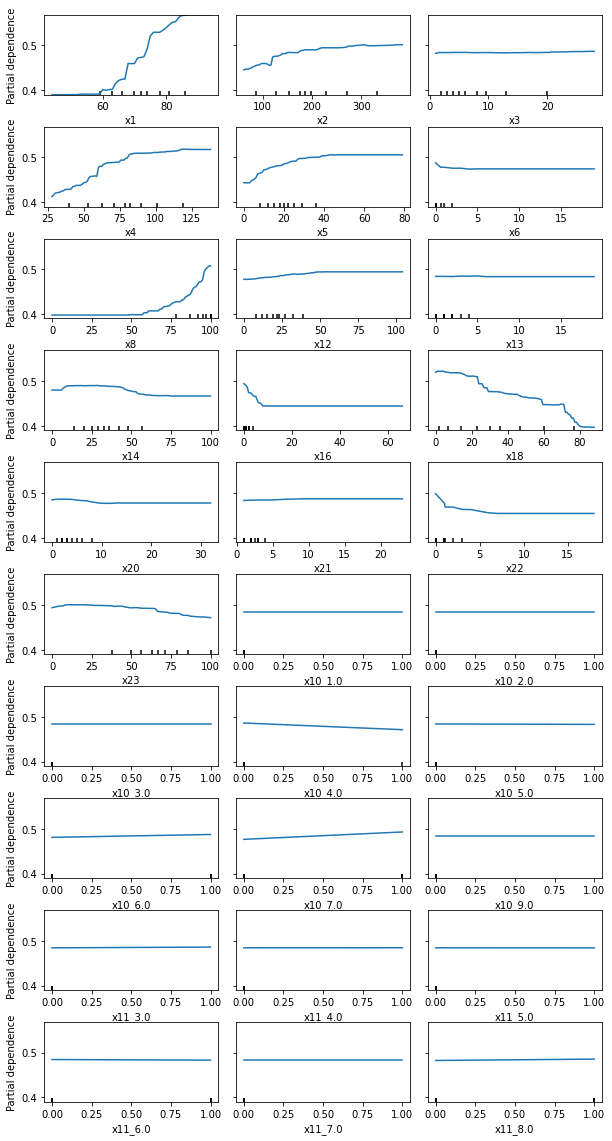

In [ ]:
#partial dependence plot
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(xgb_tuned2, X_train, X_train.columns.tolist())
fig = plt.gcf()
fig.set_size_inches(10, 20)
fig.subplots_adjust(wspace=0.1, hspace=0.4)

##f. Neural Network

In [ ]:
def X_RELU(X, tau=None,set='train'):
    X_tmp = X.copy()
    name=X.name
    if set=='train':
        K = 4
        tau = np.linspace(X_tmp.min(),X_tmp.max(),K+2)[1:-1]
        xphi = X_tmp
        for k in range(len(tau)):
            tmp = [max(x1-tau[k], 0) for x1 in X_tmp]
            xphi = np.column_stack((xphi, tmp))

    xphi = X_tmp
    for k in range(len(tau)):
        tmp = [max(x1-tau[k], 0) for x1 in X_tmp]
        xphi = np.column_stack((xphi, tmp))
        
    X_tmp = pd.DataFrame(xphi)     
    X_tmp.drop(0, axis = 1, inplace = True)
    for i in range(0,X_tmp.shape[1]+1):
        X_tmp = X_tmp.rename(columns={i: name+'_'+str(i)})

    return X_tmp, tau

In [ ]:
X_train_RELU_final_val=pd.DataFrame()
X_test_RELU_final_val=pd.DataFrame()

for column in X_train.columns[0:]:
    X_train_RELU, tau= X_RELU(X_train[column], set='train')
    X_test_RELU= X_RELU(X_test[column],tau, set='test')[0]
    X_train_RELU_final_val = pd.concat([X_train_RELU_final_val,X_train_RELU],axis=1)
    X_test_RELU_final_val = pd.concat([X_test_RELU_final_val,X_test_RELU],axis=1)

X_train_RELU = X_train_RELU_final_val.values
X_test_RELU = X_test_RELU_final_val.values

feature_names_RELU=X_train_RELU_final_val.columns[:].values
feature_names_RELU

array(['x1_1', 'x1_2', 'x1_3', 'x1_4', 'x2_1', 'x2_2', 'x2_3', 'x2_4',
       'x3_1', 'x3_2', 'x3_3', 'x3_4', 'x4_1', 'x4_2', 'x4_3', 'x4_4',
       'x5_1', 'x5_2', 'x5_3', 'x5_4', 'x6_1', 'x6_2', 'x6_3', 'x6_4',
       'x8_1', 'x8_2', 'x8_3', 'x8_4', 'x12_1', 'x12_2', 'x12_3', 'x12_4',
       'x13_1', 'x13_2', 'x13_3', 'x13_4', 'x14_1', 'x14_2', 'x14_3',
       'x14_4', 'x16_1', 'x16_2', 'x16_3', 'x16_4', 'x18_1', 'x18_2',
       'x18_3', 'x18_4', 'x20_1', 'x20_2', 'x20_3', 'x20_4', 'x21_1',
       'x21_2', 'x21_3', 'x21_4', 'x22_1', 'x22_2', 'x22_3', 'x22_4',
       'x23_1', 'x23_2', 'x23_3', 'x23_4', 'x10_1.0_1', 'x10_1.0_2',
       'x10_1.0_3', 'x10_1.0_4', 'x10_2.0_1', 'x10_2.0_2', 'x10_2.0_3',
       'x10_2.0_4', 'x10_3.0_1', 'x10_3.0_2', 'x10_3.0_3', 'x10_3.0_4',
       'x10_4.0_1', 'x10_4.0_2', 'x10_4.0_3', 'x10_4.0_4', 'x10_5.0_1',
       'x10_5.0_2', 'x10_5.0_3', 'x10_5.0_4', 'x10_6.0_1', 'x10_6.0_2',
       'x10_6.0_3', 'x10_6.0_4', 'x10_7.0_1', 'x10_7.0_2', 'x10_7.0_3',
   

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

tuned_parameters = {'solver': ['adam'],'alpha': 10.0 ** -np.arange(-4, 4,4), 'hidden_layer_sizes':[10,10,10],'random_state':[0,1,2,3]}

MLP_RELU = RandomizedSearchCV(MLPClassifier(max_iter=1000), tuned_parameters, cv=5,n_iter=10,
                       scoring='accuracy')
MLP_RELU.fit(X_train_RELU, y_train)

performance['MLP with Piecewise ReLU : ']=accuracy_score(y_test,MLP_RELU.predict(X_test_RELU)).round(4)
print('Training accuracy for the MLPClassifier with Piecewise ReLU:', accuracy_score(y_train,MLP_RELU.predict(X_train_RELU)).round(4))
print('Testing accuracy for the MLPClassifier with Piecewise ReLU:', accuracy_score(y_test,MLP_RELU.predict(X_test_RELU)).round(4))
MLP_RELU

Training accuracy for the MLPClassifier with Piecewise ReLU: 0.712
Testing accuracy for the MLPClassifier with Piecewise ReLU: 0.7189


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=1000,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           rando...
                                           solver='adam', tol=0.0001,
                                           validation_fraction=0.1,
                                         


[[ 0.18211336  0.10761349  0.07835413 ...  0.          0.
   0.        ]
 [ 0.19414117  0.11706507  0.09066505 ...  0.          0.
   0.        ]
 [ 0.10429245  0.0418404   0.02103324 ...  0.          0.
   0.00066863]
 ...
 [-0.09213151 -0.02649931 -0.0270788  ...  0.          0.
   0.        ]
 [ 0.          0.         -0.02607195 ...  0.          0.
   0.        ]
 [ 0.14373704  0.07615778  0.0679298  ...  0.          0.
   0.        ]]
[0.3680809726169261, 0.01589022684297184, 0.0, -0.01535764343756809, -0.020567292903446208, 0.0, 0.01902132144849983, 0.0, 0.0, 0.045468811178152546, 0.0, 0.04985039459952765, 0.0, 0.0, 0.0, 0.0456580702185968, 0.0, 0.0, 0.0, 0.0, 0.00627091913559652, 0.0, 0.0, 0.0, 0.0, 0.005684220300742893, 0.0, 0.0, 0.0, 0.0]
[0.4018712903005297, -0.022890432516824044, 0.0, 0.022689919050247587, -0.04879657490806327, 0.0, 0.03836104699522047, 0.0, 0.009819048480084414, 0.0329368822632386, 0.0, 0.04957843181711408, 0.0, 0.0, 0.0, 0.023621982347665826, 0.0043302954

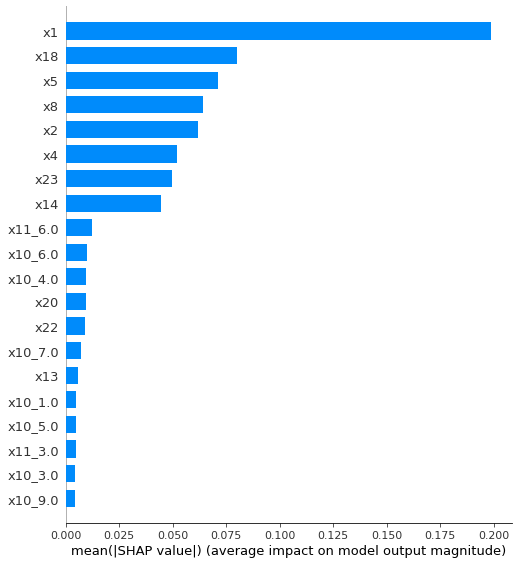

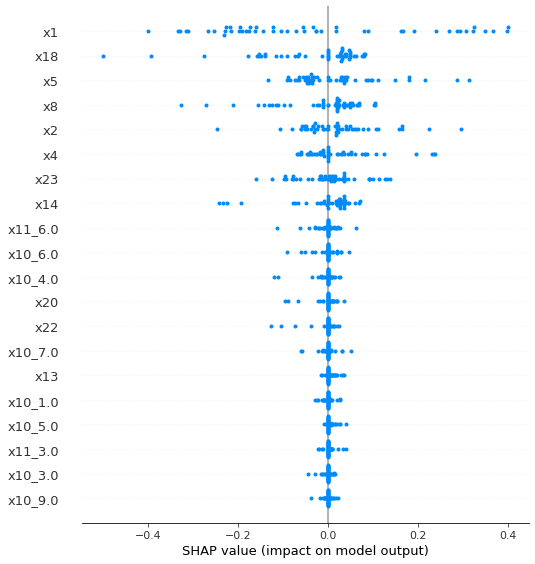

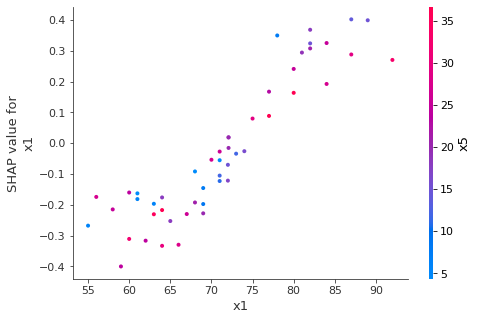

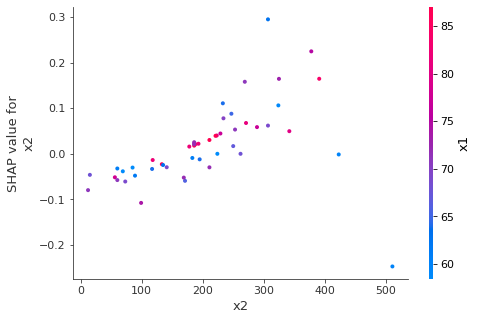

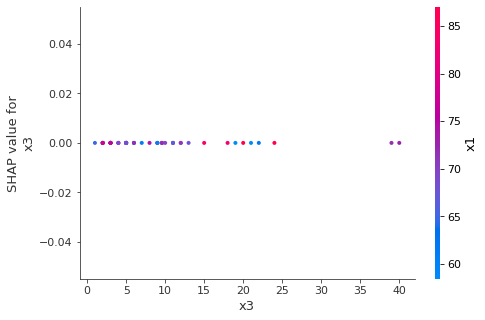

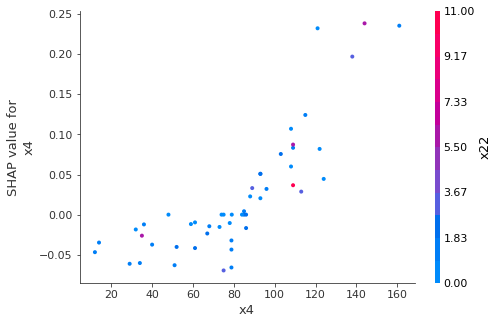

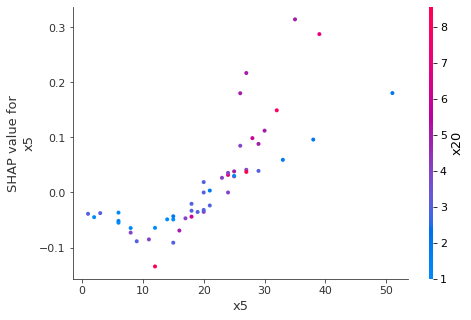

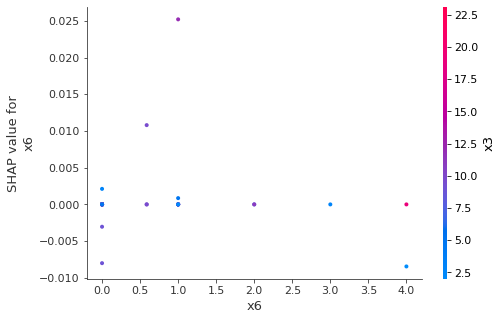

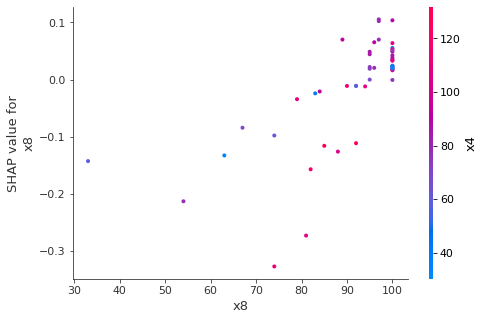

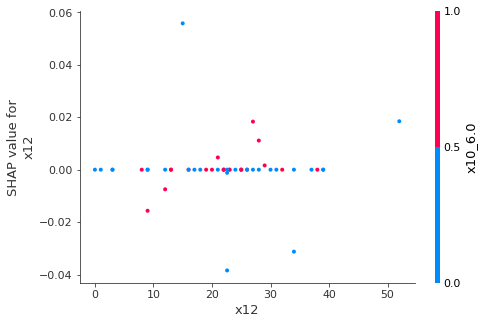

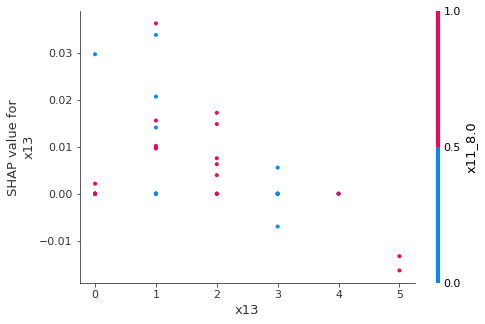

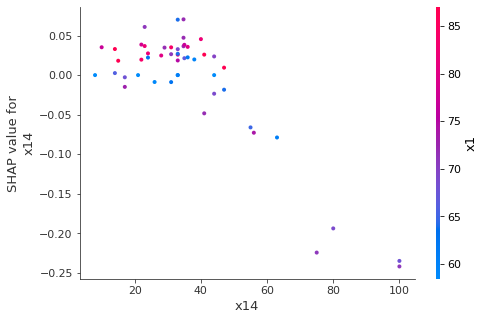

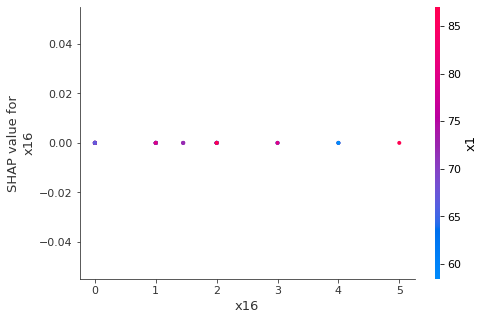

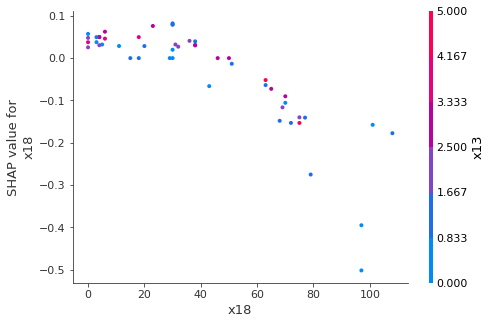

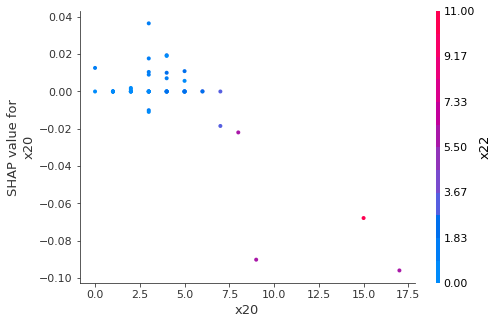

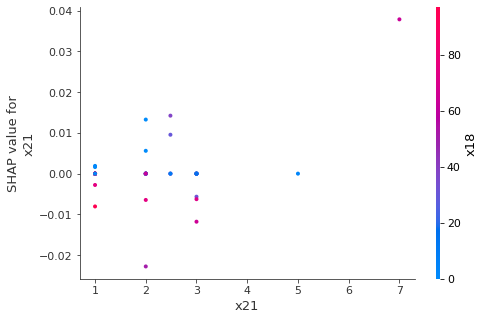

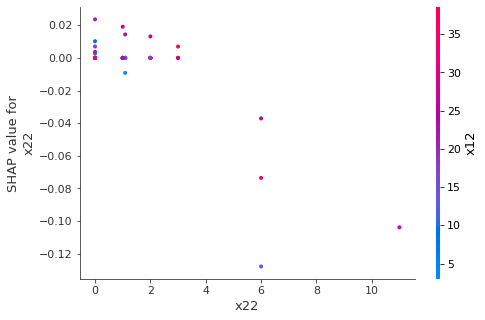

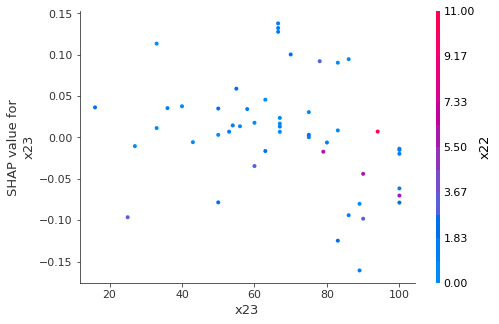

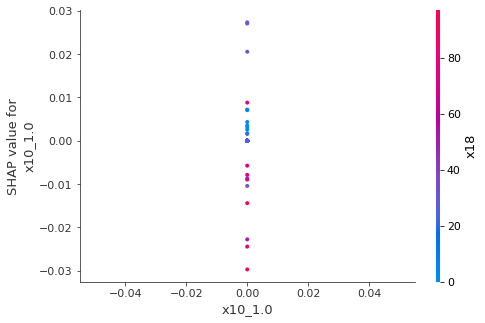

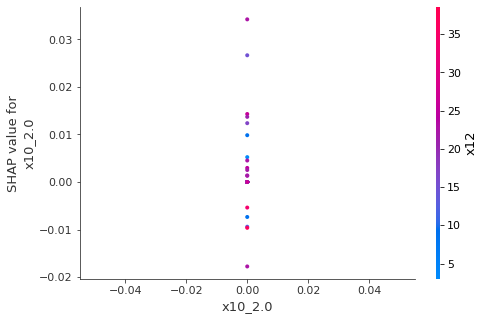

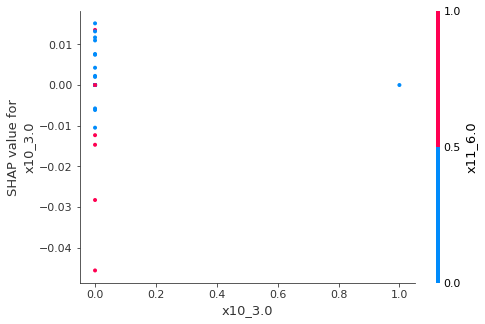

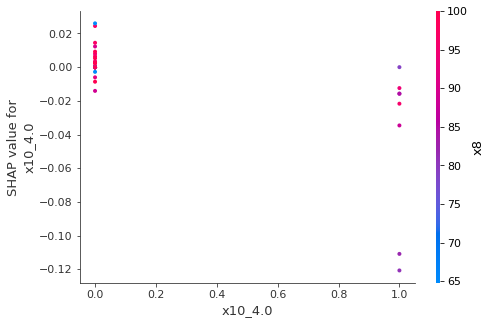

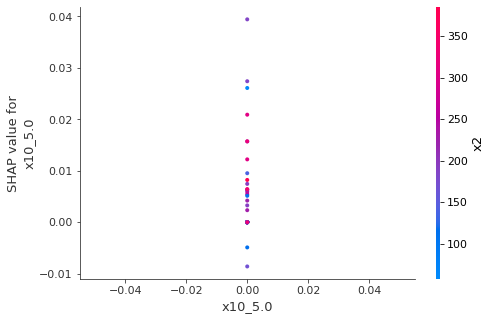

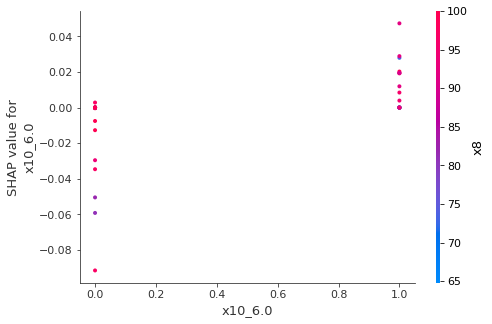

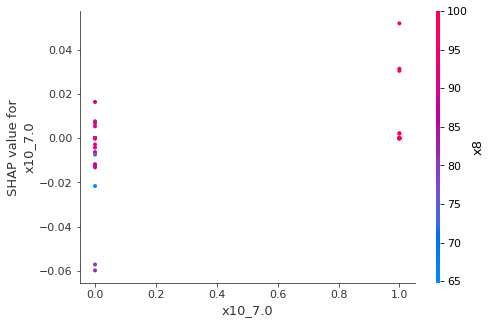

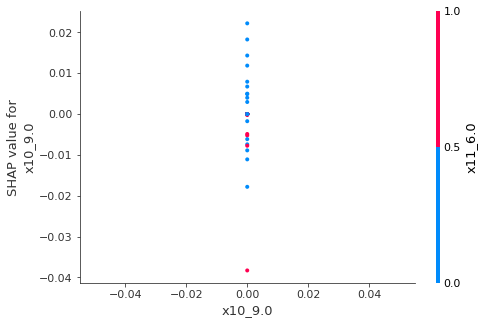

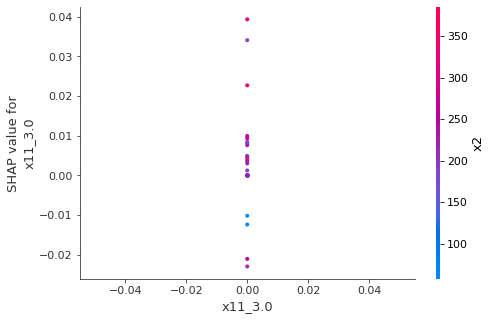

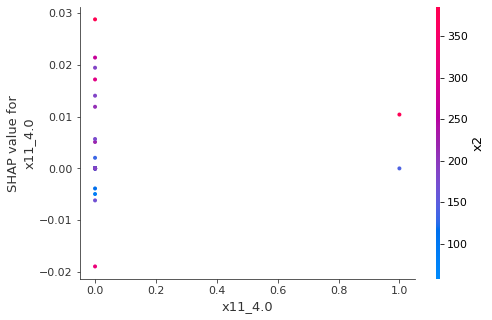

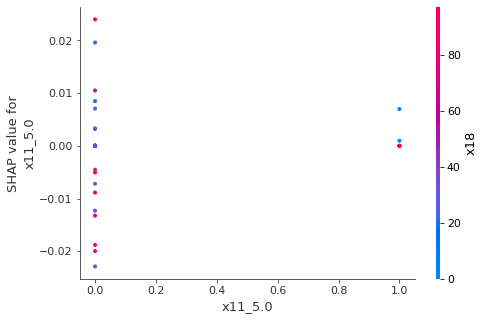

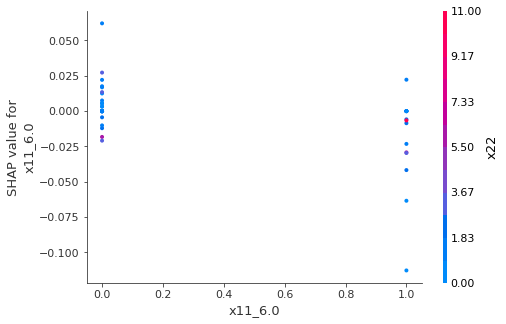

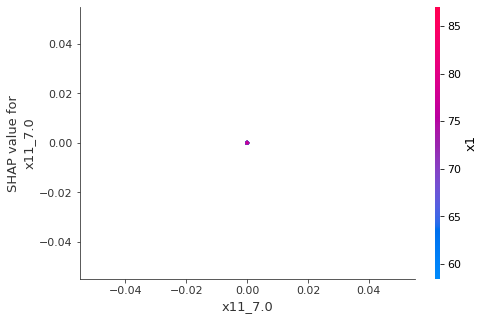

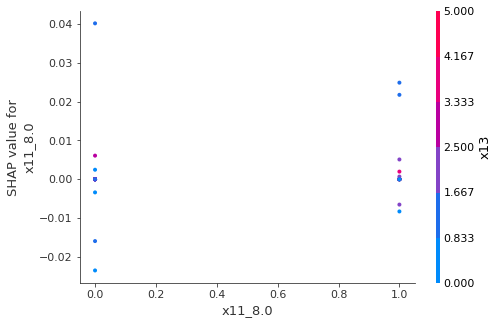

In [ ]:
import shap
feature_names=X_train.columns.tolist()

def IntergrateSHAP(feature_names,feature_names_raw,shap_range,shap_values):
  feature_list = list(feature_names).copy()
  shap_integrated_all=[]
  for i in range(shap_range):
    shap_integrated=[]
    for column in feature_names_raw:
        shap_integrating = 0
        for feature_name in feature_names:
            if feature_name.startswith(column+'_'):
                feature_index = feature_list.index(feature_name)
                shap_integrating = shap_integrating + shap_values[i][feature_index]
        shap_integrated.append(shap_integrating)
    print(shap_integrated)
    shap_integrated_all.append(shap_integrated)
  return shap_integrated_all

def PlotSHAP(MLP_BinAll,x_train_BinAll,feature_names_BinAll,x_train_raw,feature_names_raw,shap_range):
  # define the explainer
  explainer = shap.KernelExplainer(MLP_BinAll.predict,shap.sample(x_train_BinAll, 50))
  # calculate the shape value on training data
  # set approximate=True for fast processing
  shap_values = explainer.shap_values(x_train_BinAll[:shap_range], approximate=True)
  print(shap_values)
  

  ## shap_values_int = shap values after integration, it is a np.array with shape: (shap_range,12)
  ## feature_names = np.array(['x1','x2',...,'x23'])
  shap_values_int=np.array(IntergrateSHAP(feature_names_BinAll,feature_names_raw,shap_range,shap_values))
  feature_names=X_train.columns.tolist()

  shap.summary_plot(np.array(shap_values_int), feature_names=feature_names, plot_type='bar')
  shap.summary_plot(np.array(shap_values_int), feature_names=feature_names)
  
  # plot pdp
  for column in feature_names_raw:
    shap.dependence_plot(column, shap_values_int, x_train_raw[:shap_range], feature_names=feature_names)
  
  return (shap_values_int,feature_names)

(shap_values_int,feature_names) = PlotSHAP(MLP_RELU,X_train_RELU,feature_names_RELU,X_train,feature_names,50)

# 6. Set 2: With Monotonicity Constraints

a. General Additive Model<br>
b. Gradient Boosting: XGBoost<br>
c. Neural Network<br>


We have chosen one model each from three different methods for binary classification problem: <br>**GAM** -> Regression,<br> **XGboost** -> Tree-based,<br> and **Monotone MLP** -> ANN.

We applied different types of monotonic constraints on each feature (inreasing or decreasing or no) based on the information given by HelocDataDict.xlsx. 

## a. General Additive Model

100% (11 of 11) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


Accuracy on the training set for GAM with monotonicity constraint:  0.7006346545323914
Accuracy on the test set for GAM with monotonicity constraint:  0.7031548757170172


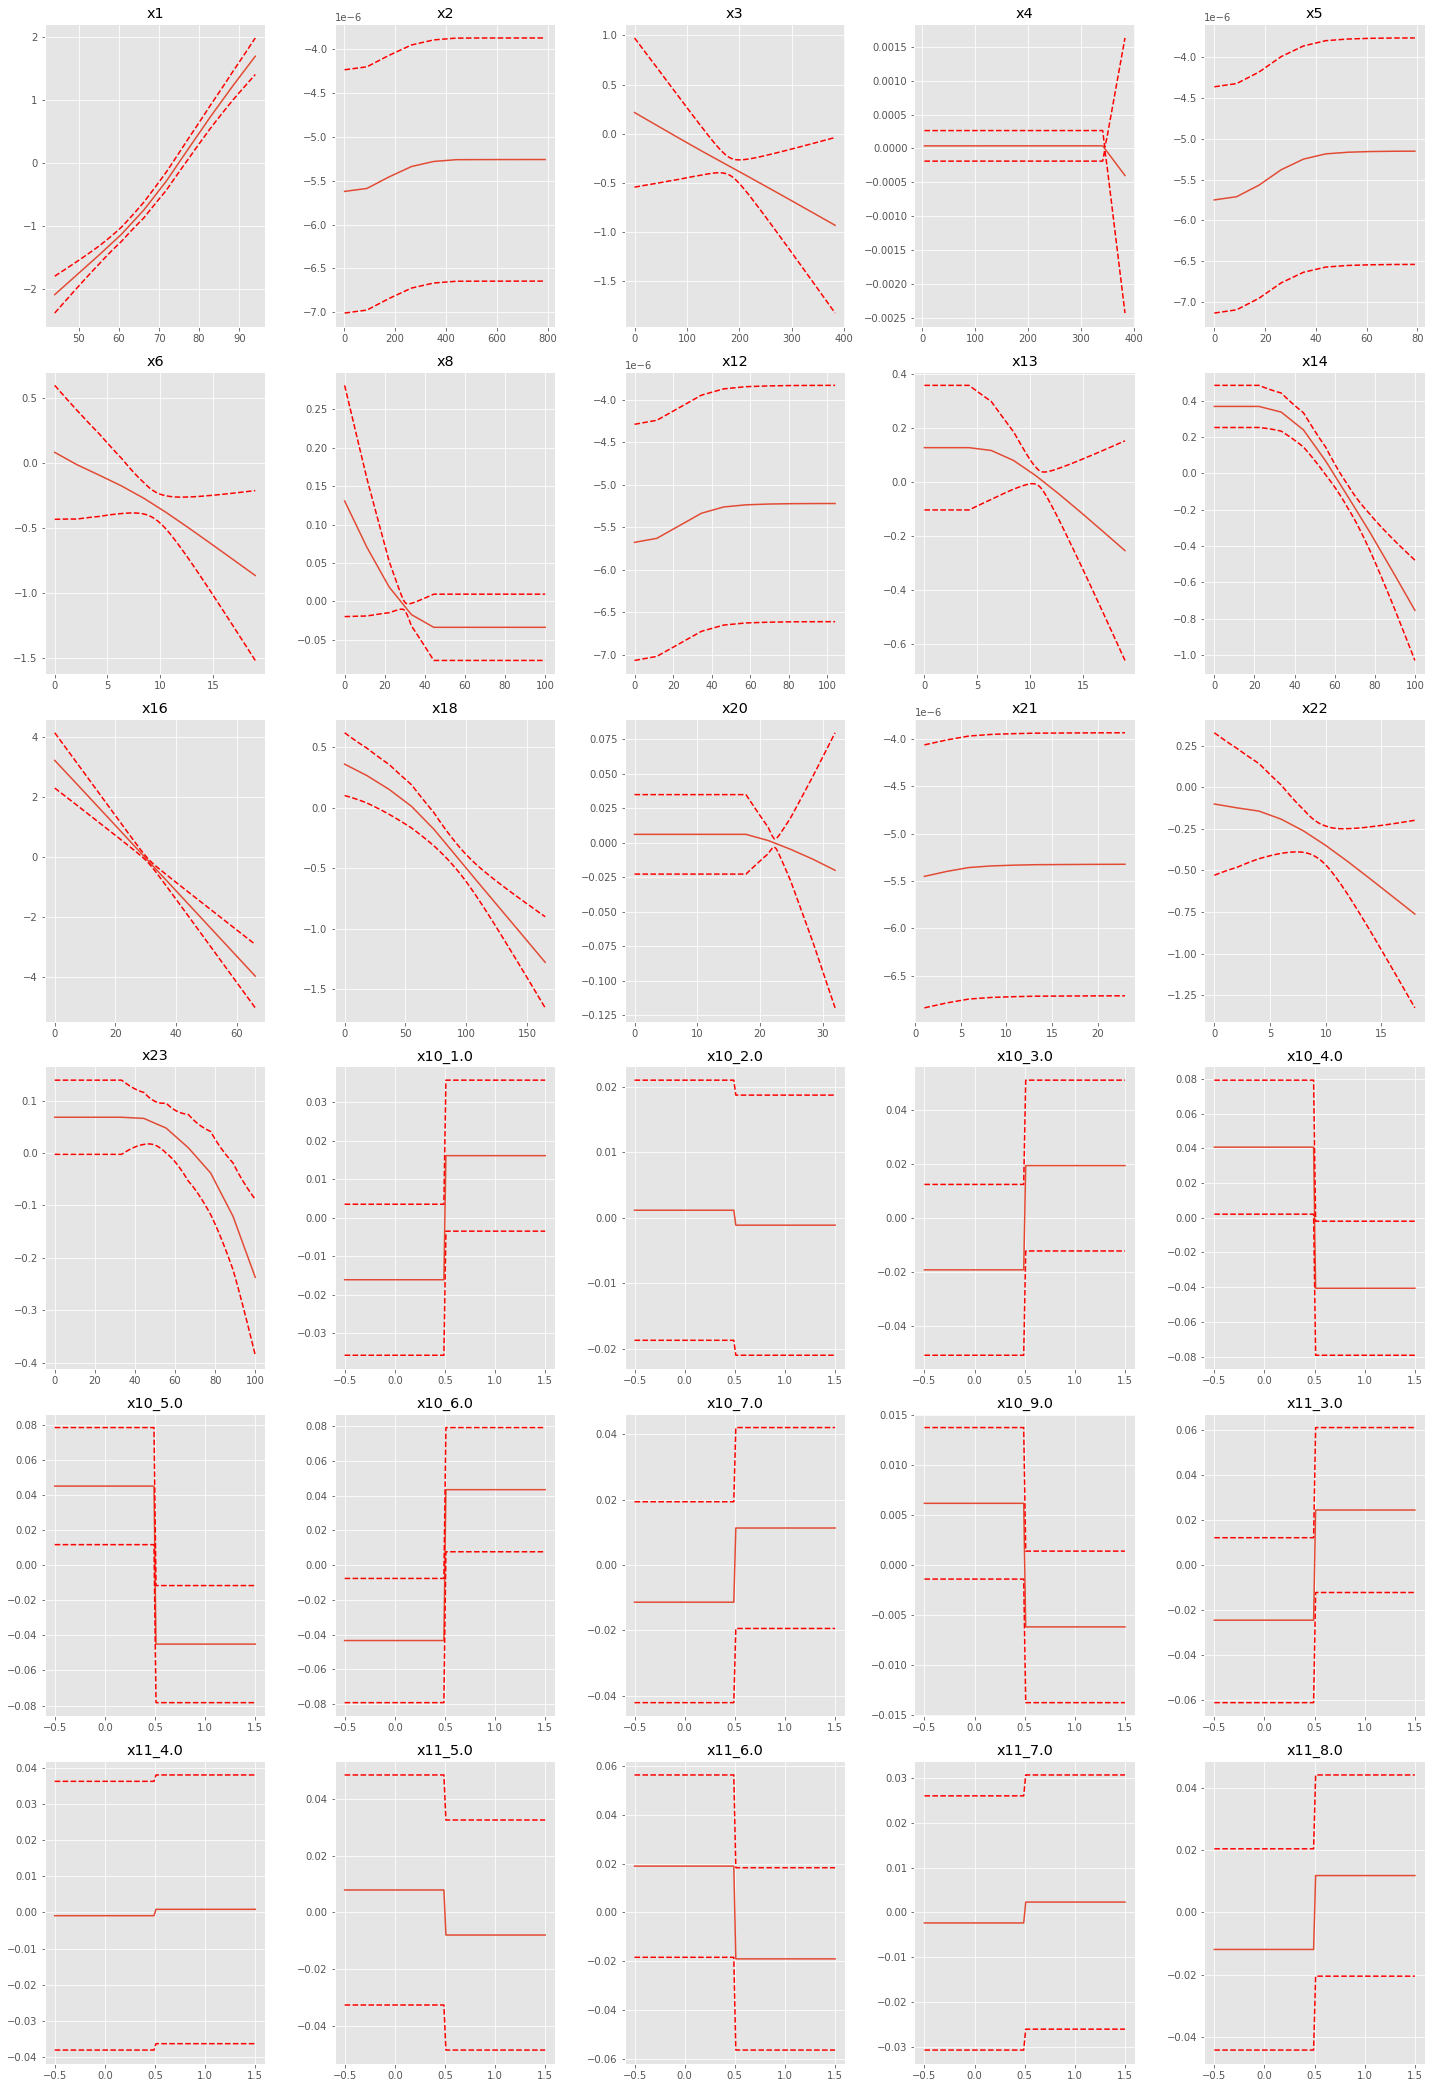

In [ ]:
from pygam import LogisticGAM, s,f

X_train_GAM_mono = X_train.iloc[:,0:].values
X_test_GAM_mono= X_test.iloc[:,0:].values
n_splines = 10

m=s(0,n_splines=n_splines,spline_order=1,constraints='monotonic_inc')

for i in range(1,16):
  if i==5 or 8 or 10 or 11:
    m+= s(i,n_splines=n_splines, spline_order=1,constraints='monotonic_dec')
  elif i==7 or 9 or 12 or 13 or 15:
    m+= s(i,n_splines=n_splines, spline_order=1)
  else:
    m+= s(i,n_splines=n_splines, spline_order=1,constraints='monotonic_inc')

for j in range(16,30):
  m+= f(j)

GAM_mono=LogisticGAM(m)

GAM_mono.gridsearch(X_train_GAM_mono,y_train)

y_train_gamono_pred = GAM_mono.predict(X_train_GAM_mono)
y_test_gamono_pred = GAM_mono.predict(X_test_GAM_mono)

accuracy_train_gamono = accuracy_score(y_train,y_train_gamono_pred)
accuracy_test_gamono = accuracy_score(y_test,y_test_gamono_pred)

performance['General Additive Model with monotonicity constraints : ']=accuracy_test_gamono.round(4)
print('Accuracy on the training set for GAM with monotonicity constraint: ',accuracy_train_gamono)
print('Accuracy on the test set for GAM with monotonicity constraint: ',accuracy_test_gamono)


cols = 5 
rows = (X_train.shape[1]-1)//cols + 1 

fig = plt.figure(figsize=(20, 5*rows))
for i, var_name in enumerate(X_train.columns):
    ax = fig.add_subplot(rows,cols,i+1)
    XX = GAM_mono.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:, i], GAM_mono.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], GAM_mono.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(X_train.columns[i])
    
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
y_train.values.reshape(-1,1)

array([[1],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

##b. Boosting: XGBoost

In [ ]:
import numpy as np
import xgboost as xgb


feature_names = X_train.columns.tolist()
feature_ids = [feature_names.index(f) for f in feature_names]

dtrain = xgb.DMatrix(X_train[feature_names].values.reshape(len(X_train), len(feature_ids)), label = y_train)
dtest =  xgb.DMatrix(X_test[feature_names].values.reshape(len(X_test), len(feature_ids)), label = y_test)

# Setting variable monotonicity constraints
# 0: no constraint, 1: positive, -1: negative
feature_monotones = [1,1,1,1,1,-1,1,0,-1,0,-1,-1,0,0,-1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1]

params = {'max_depth': 4,
          'min_child_weight': 3,
          'eta': 0.1,
          'silent': 1,
          'nthread': 2,
          'seed': 1,
          'eval_metric': 'error',

          # E.g. fitting three features with positive, negative and no constraint
          # 'monotone_constraints': (1,-1,0)
          'monotone_constraints': '(' + ','.join([str(m) for m in feature_monotones]) + ')'
         }

# Use CV to find the best number of trees
bst_cv = xgb.cv(params, dtrain, 1000, nfold = 5, early_stopping_rounds=30)

# Train on the entire training set, evaluate performances on the testset
evallist  = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round = bst_cv.shape[0], evals_result = evals_result, evals = evallist,  verbose_eval = False)

print('Number of boosting rounds %d,\
       Training Accruacy: %.4f, \
       Testing Accuracy: %.4f' % \
       (
        len(evals_result['train']['error']),
        1-evals_result['train']['error'][-1],
        1-evals_result['eval']['error'][-1]
        ))
performance['XGB with monotonicity constraints : ']=0.714

Number of boosting rounds 48,       Training Accruacy: 0.7285,        Testing Accuracy: 0.7141


In [ ]:
def partial_dependency(bst, X, y, f):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()

    grid = np.linspace(np.percentile(X_temp[f].values, 0.1),
                       np.percentile(X_temp[f].values, 99.5),
                       50)
    y_pred = np.zeros(len(grid))


    for i, val in enumerate(grid):

            X_temp[f] = val
            data = xgb.DMatrix( X_temp.values.reshape( (len(X_temp), 30) ) )

            y_pred[i] = np.average(bst.predict(data, ntree_limit = bst.best_ntree_limit))

    return grid, y_pred

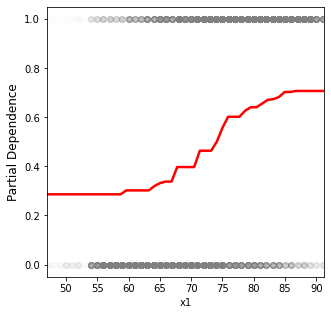

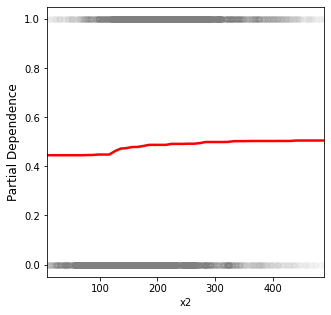

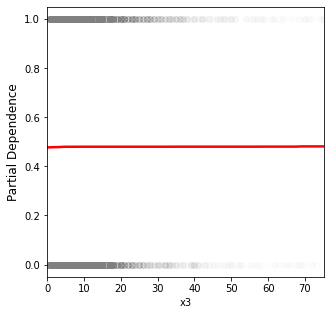

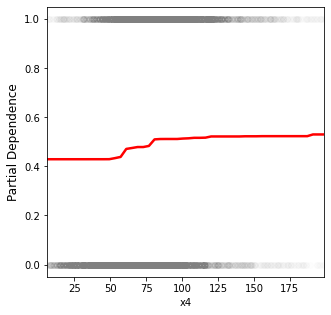

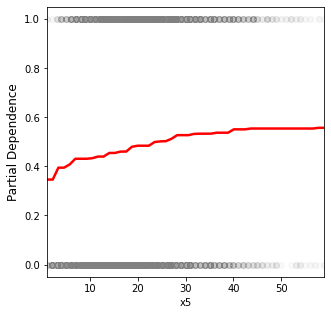

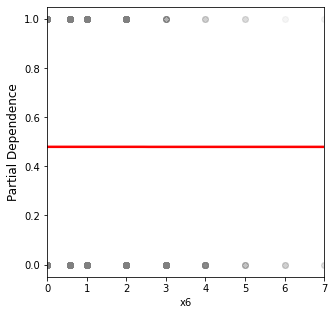

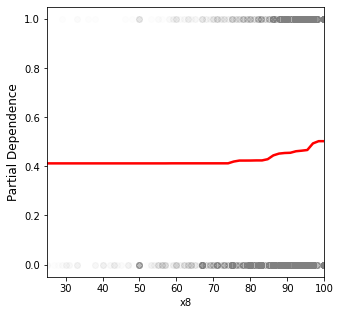

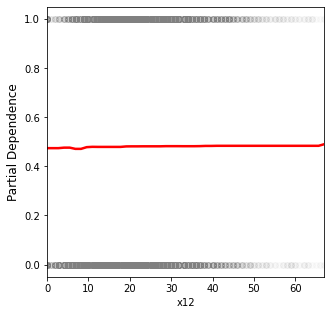

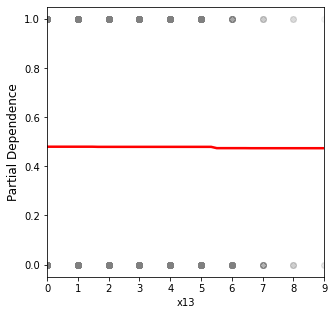

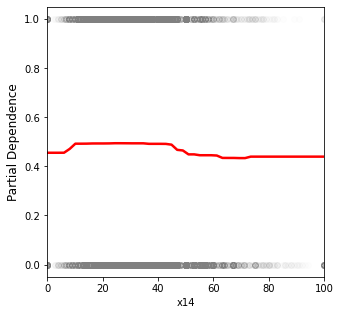

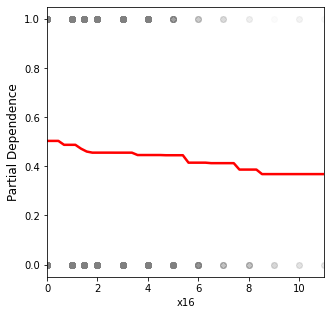

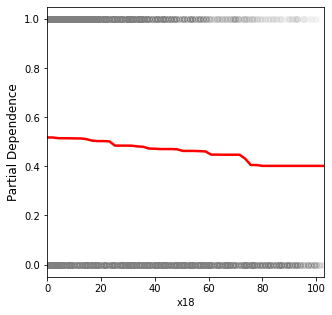

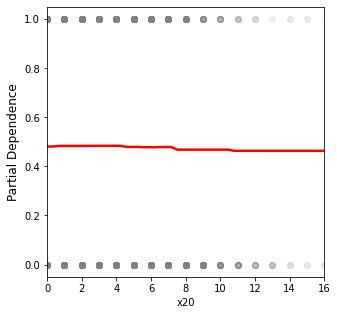

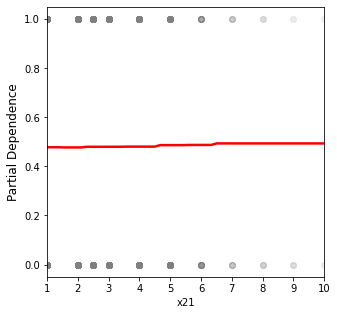

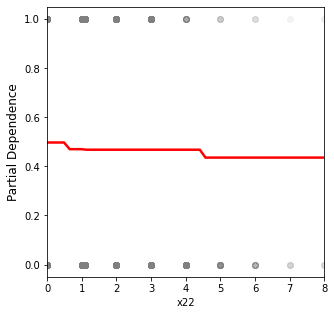

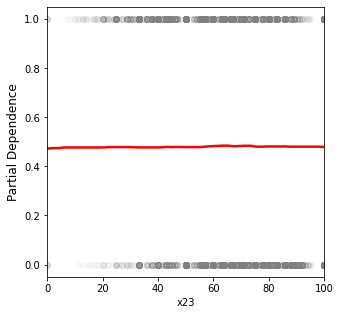

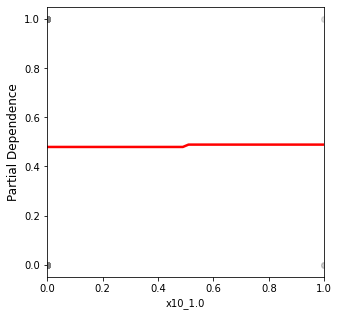

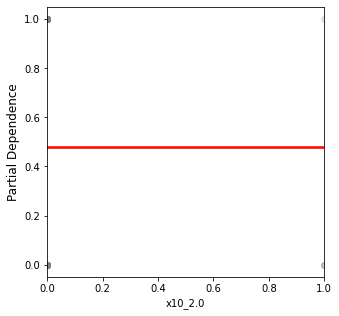

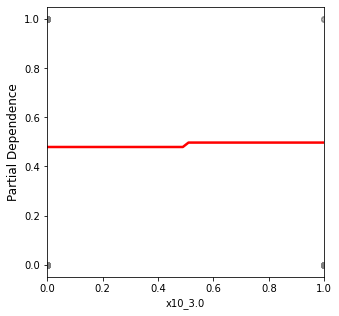

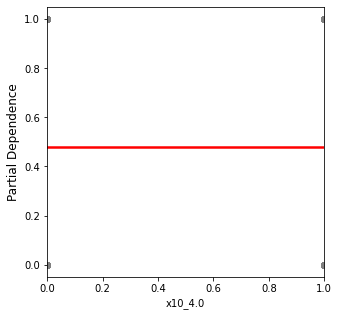

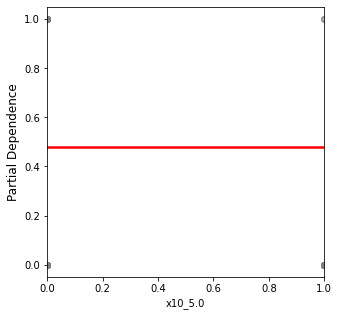

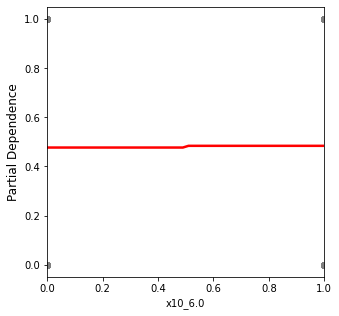

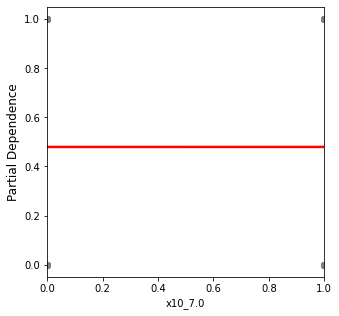

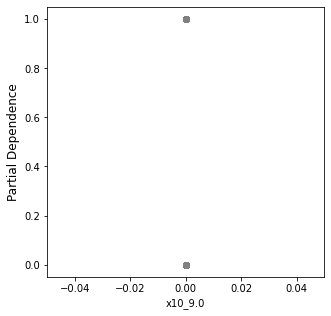

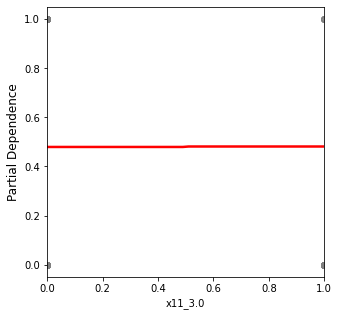

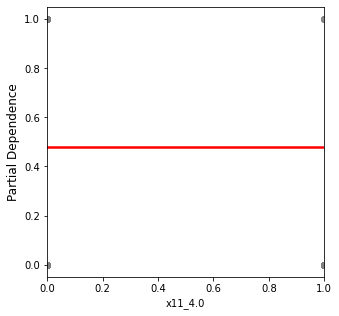

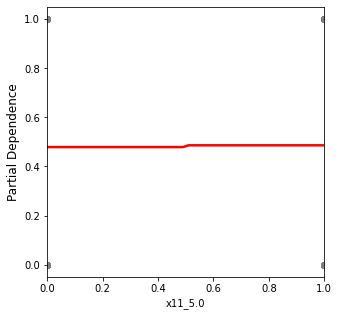

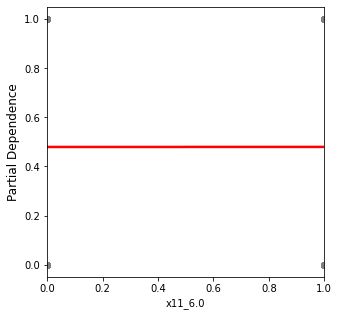

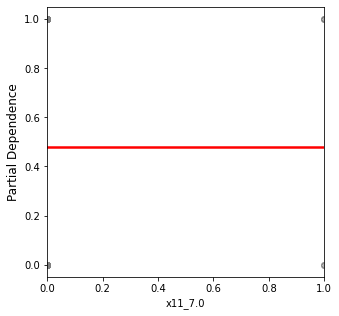

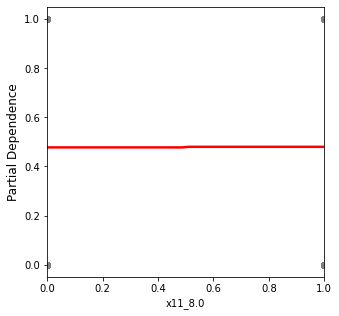

In [ ]:
for f in feature_names:

    grid, y_pred = partial_dependency(bst,
                                      X_train,
                                      y_train,
                                      f
                                     )

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(grid, y_pred, '-', color = 'red', linewidth = 2.5, label='fit')
    ax.plot(X_train[f].values, y_train, 'o', color = 'grey', alpha = 0.01)

    ax.set_xlim(min(grid), max(grid))
    ax.set_xlabel(f, fontsize = 10)
    ax.set_ylabel('Partial Dependence', fontsize = 12)
    handles, labels = ax.get_legend_handles_labels()

## c. Neural Network

The monotonically constrained ANN: monotone MLP were implemented through R studio. Please refer to the 3612_final_reference.r file for details.

### The R Code used

```
install.packages("monmlp")
install.packages("plotly")
install.packages("sigmoid")
install.packages("caret")
install.packages("tidyverse")
install.packages("tidyselect")
install.packages("lattice")
install.packages("ggplot2")
install.packages("optimx")
library(monmlp)
library(optimx)
library(tidyselect)
library(lattice)
library(ggplot2)
library(caret)
library(nnet)
library(plotly)
library(sigmoid)
#----------------------------------------------------------------------------------
# Data Preparation
#----------------------------------------------------------------------------------
#Call X and y train and test set (Exactly the same set used in the original ipynb)
#X_test, X_train, y_test, y_train are enclosed
X_test <- read.csv(file='/Users/inbum/Desktop/X_test.csv')
X_train <- read.csv(file='/Users/inbum/Desktop/X_train.csv')
y_test <- read.csv(file='/Users/inbum/Desktop/y_test.csv')
y_train <- read.csv(file='/Users/inbum/Desktop/y_train.csv')

X_train <- X_train[,-c(1)]
X_test <- X_test[,-c(1)]
y_train <- y_train[,-c(1)]
y_test <- y_test[,-c(1)]

X_train_mat <- as.matrix(X_train)
X_test_mat <- as.matrix(X_test)
y_train_mat <- as.matrix(y_train)
y_test_mat <- as.matrix(y_test)

#----------------------------------------------------------------------------------
# Monotone MLP
#----------------------------------------------------------------------------------
#Fitting Monotone MLP
monoMLP <- monmlp.fit(x = X_train_mat, y = y_train_mat,
                      To = tansig, To.prime = tansig.prime,
                      hidden1 = 8, monotone = c(1:4,6,8,13,14), scale = F,
                      n.ensemble = 10, bag = TRUE, iter.max = 500)

#Prediction
p_monoMLP <- attr(monoMLP, "y.pred")
p_monoMLP <- p_monoMLP[,1]
p_monoMLP <- monmlp.predict(x = X_test_mat, weights = monoMLP)

#Decision
pred <- p_monoMLP
pred_df <- as.data.frame(pred)
pred_df[pred_df <= 0.5] <- 0
pred_df[pred_df > 0.5] <- 1

#Transforming the prediction and y_test into factor form in order to fit into the confusionMatrix()
pred_mat <- as.matrix(pred_df)
pred_fac <- as.factor(pred_mat)
y_test_fac <- as.factor(y_test)

#Accuracy on the test set
confusionMatrix(pred_fac, y_test_fac, mode="prec_recall")

#Feature Importance
filterVarImp(X_train,y_train) ```



### Performance



```
Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 731 234
         1 361 766
                                          
               Accuracy : 0.7156          
                 95% CI : (0.6957, 0.7348)
                 Mcnemar's Test P-Value : 2.398e-07       
                                          
              Precision : 0.7575          
                 Recall : 0.6694          
                     F1 : 0.7107          
             Prevalence : 0.5220          
         Detection Rate : 0.3494          
   Detection Prevalence : 0.4613          
      Balanced Accuracy : 0.7177  
```



In [ ]:
performance['ANN with monotonicity constraints : ']=0.7156


### Feature Importance


```
#Feature Importance
> filterVarImp(X_train,y_train) 
          Overall
x1      45.277328
x2      19.669842
x4      22.184889
x6      16.002521
x14     12.867807
x18     32.691262
x22     21.261469
x23     26.005984
x3       4.355868
x5      13.418895
x8      23.121346
x12      9.929871
x13      6.452359
x16     13.531976
x20     10.556065
x21      4.130906
x10_1.0  1.398924
x10_2.0  2.739047
x10_3.0  4.744112
x10_4.0 15.994511
x10_5.0  6.020016
x10_6.0  2.554041
x10_7.0 20.410168
x10_9.0  1.246484
x11_3.0  3.067101
x11_4.0  5.100478
x11_5.0  8.033424
x11_6.0  8.027504
x11_7.0  1.035331
x11_8.0 19.234175```



# 7. Analysis and Conclusion

a. Model performance<br>

b. Model Interpretability<br>

c. Conclusion

## a. Model performance

In [ ]:
models_without_mono=['Logistic Regression with IV binning : '
        ,'General Additive Model with Piecewise ReLU : ','RBF SVC : ',
        'Decision Tree : ','XGB with lower learning rate : ','MLP with Piecewise ReLU : ']

models_with_mono=['General Additive Model with monotonicity constraints : '
        ,'XGB with monotonicity constraints : ','ANN with monotonicity constraints : ']

print("WITHOUT MONOTONICITY CONSTRAINTS")
performance_without_mono = {key: performance[key] for key in models_without_mono}
ordered_performance_without_mono =dict(sorted(performance_without_mono.items(), key=lambda item: item[1]))
for model, accuracy in ordered_performance_without_mono.items(): 
    print(model, accuracy) 

print("\nWITH MONOTONICITY CONSTRAINTS")
performance_with_mono = {key: performance[key] for key in models_with_mono}
ordered_performance_with_mono =dict(sorted(performance_with_mono.items(), key=lambda item: item[1]))
for model, accuracy in ordered_performance_with_mono.items(): 
    print(model, accuracy) 



WITHOUT MONOTONICITY CONSTRAINTS
General Additive Model with Piecewise ReLU :  0.7075
Logistic Regression with IV binning :  0.7089
Decision Tree :  0.7089
RBF SVC :  0.7137
MLP with Piecewise ReLU :  0.7189
XGB with lower learning rate :  0.7194

WITH MONOTONICITY CONSTRAINTS
General Additive Model with monotonicity constraints :  0.7032
XGB with monotonicity constraints :  0.714
ANN with monotonicity constraints :  0.7156


**For set 1:** <br> As from the result, the performance of XGBoost was the highest among the models with 0.7194. By comparing XGboost with other black-box models, it shows the outstanding performance, while having similar interpretability as SVM and much better interpretability from ANN.<br> Comparing XGboost with other white-box models, although XGboost have lower interpretability, but there exists significant different in the performance.<br>
**Hence we chose XGboost as our final model**, and attempted to increase the interpretability through model-agnostic methods.<br>

**For set 2:**<br> Although Monotone MLP have the highest performance, the interpretability is much lower comparing other two models. <br>
While GAM model have the highest interpretability, the model performance is significantly lower than other two.<br>
Therefore, **we have chosen XGBoost as our final model for the corresponding set** as well becaue the performance is closer to the Monotone MLP while interpretability is meaningfully higher.

## b. Model Interpretability



### Global Interpretability

Feature Importance for XGBoost without monotonicity constraints

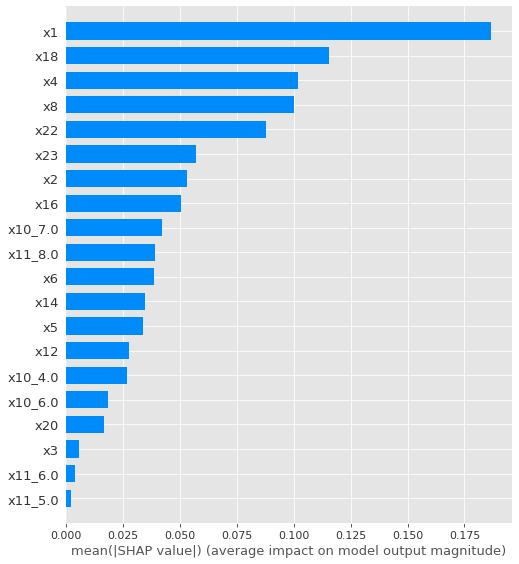

In [ ]:
shap.summary_plot(shap_values_xgb_tuned2, X_train, plot_type="bar")

Feature Importance for XGBoost with monotonicity constraints

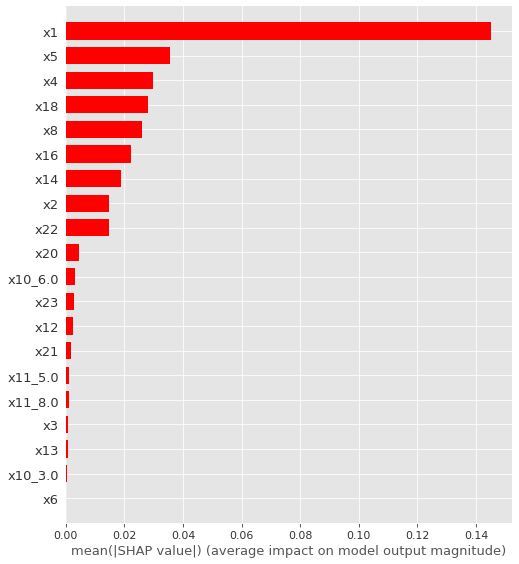

In [ ]:
shap.summary_plot(shap_values_bst, X_train, plot_type="bar",color="red")

For **Partial Dependence Plots** for each feature, please refer to the section 5e and 6b.

Bivariate PDP for top 2 features (Consolidated version of risk markers [x1] and Net fraction revolving burden [x18]

In [ ]:
!pip install pdpbox

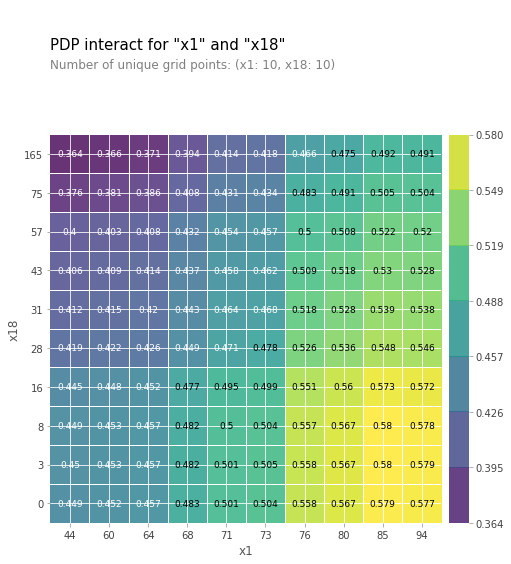

In [ ]:
from pdpbox import pdp
features_to_plot = ['x1', 'x18']
inter1  =  pdp.pdp_interact(model=xgb_haha, dataset=X_train,model_features= X_train.columns,features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')

plt.show()

We can have different bivariabe pdp so it increases the interpretability when two features come together to affect the riskflag.

### Local Interpretability

SHAP for XGBoost without monotonicity constraints

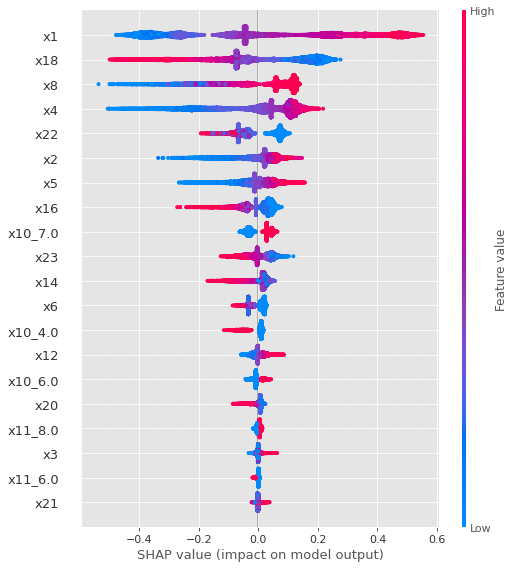

In [ ]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb_tuned2)
shap_values_xgb_haha = explainer.shap_values(X_train)

# create a dependence plot to show the effect of a single feature across the whole dataset
shap.summary_plot(shap_values, X_train)

Partial Dependence Plot for XGBoost with monotonicity constraints

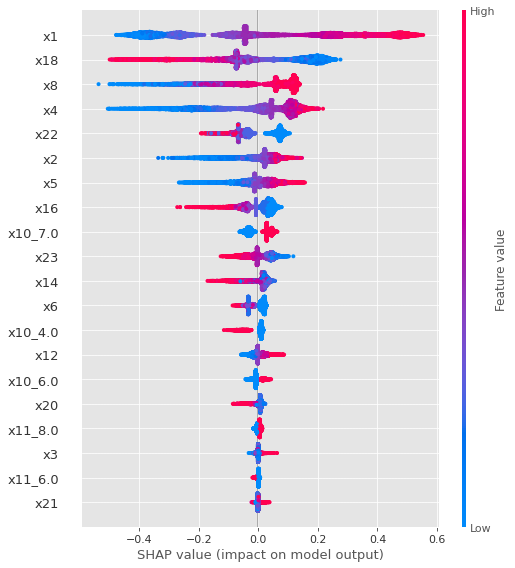

In [ ]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(bst)
shap_values_bst = explainer.shap_values(X_train)

# create a dependence plot to show the effect of a single feature across the whole dataset
shap.summary_plot(shap_values, X_train)

**Thank You :)**